In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from kaggle_titanic_helpers import *

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
# Getting spend cols
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [4]:
# These people are not in the same cabin, but in same passenger group
# Need to look at capacity of cabin sizes
train[train['PassengerId'].apply(lambda x: str(x[:4]))=='0006']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True


In [5]:
# Quick view of Transported by each variable
train.groupby('Transported').count()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
Transported,,,,,,,,,,,,,
False,4315,4217,4204,4216,4225,4226,4216,4217,4231,4221,4223,4225,4216
True,4378,4275,4272,4278,4286,4288,4274,4295,4279,4264,4287,4280,4277


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [7]:
train.count()

PassengerId     8693
HomePlanet      8492
CryoSleep       8476
Cabin           8494
Destination     8511
Age             8514
VIP             8490
RoomService     8512
FoodCourt       8510
ShoppingMall    8485
Spa             8510
VRDeck          8505
Name            8493
Transported     8693
dtype: int64

In [8]:
train.dropna().count()

PassengerId     6606
HomePlanet      6606
CryoSleep       6606
Cabin           6606
Destination     6606
Age             6606
VIP             6606
RoomService     6606
FoodCourt       6606
ShoppingMall    6606
Spa             6606
VRDeck          6606
Name            6606
Transported     6606
dtype: int64

In [9]:
# Checking Null Values
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
def basic_prep(df):
    df[['deck', 'number', 'side']] = pd.DataFrame(
        df.Cabin.apply(lambda x: str(x).split('/')).tolist(),
        index= df.index,
        columns=['deck', 'number', 'side'],
    )
    # PassengerId follows XXXX_XX structure for all
    df['passenger_group'] = df['PassengerId'].apply(lambda x: str(x[:4]))
    df['num_group'] = df['PassengerId'].apply(lambda x: x[-2:])
    
    df['total_spend'] = df[spend_cols].sum(axis=1)
    df = df.join(df.groupby('passenger_group')\
                   .agg({'total_spend':'sum','num_group':'max'}),on='passenger_group',rsuffix='_max')
    df['num_group_max'] = df['num_group_max'].astype('int')
    
    df['surname'] = df[df['Name'].notna()].Name.apply(lambda x: str(x).split(" ")[-1])
    
    df.replace({'nan':np.nan},inplace=True) # Needed, since split above creates "nan"
    df.number = df.number.astype(float)


    # Setting up error handling as test_df doesn't have "Transported"
    try:
        df["Transported"] = df["Transported"].replace({True: 1, False: 0})
    except:
        pass
    return df

In [11]:
def fill_missing_basic(df, float_cols, object_cols):
    df[spend_cols] = df[spend_cols].fillna(df[spend_cols].mean())
    df[float_cols] = df[float_cols].fillna(df[float_cols].mean().to_dict())
    object_dict = {k:v[0] for k, v in df[object_cols].mode().to_dict().items()}
    df[object_cols] = df[object_cols].fillna(object_dict)
    return df

In [12]:
train_df = basic_prep(train)
test_df = basic_prep(test)

In [13]:
train_df = fill_cryosleep(train_df)

217 Initially
98 After Step 1: Spending Money = No CryoSleep
61 After Step 2: 1 Passenger / Zero Spend = CryoSleep
43 After Step 3: Total Group Spend Zero = CryoSleep
0 After Step 4: Total Group Spend > Zero = No CryoSleep


In [14]:
test_df = fill_cryosleep(test_df)

93 Initially
38 After Step 1: Spending Money = No CryoSleep
23 After Step 2: 1 Passenger / Zero Spend = CryoSleep
16 After Step 3: Total Group Spend Zero = CryoSleep
0 After Step 4: Total Group Spend > Zero = No CryoSleep


In [15]:
train_df = fill_homeplanet(train_df)

201 Initially
111 after filling passenger groups
104 after filling Europa decks
63 after filling Earth decks
0 after filling the rest with Earth


In [16]:
test_df = fill_homeplanet(test_df)

87 Initially
46 after filling passenger groups
40 after filling Europa decks
31 after filling Earth decks
0 after filling the rest with Earth


In [17]:
float_cols = list(train.dtypes[train.dtypes==float].index)
object_cols = list(train.dtypes[train.dtypes==object].index)

In [18]:
drop_cols = ['Name', 'PassengerId', 'Cabin']
# change_cols = ['VIP', 'CryoSleep']
for i in drop_cols:
    object_cols.remove(i)

In [19]:
train_df = fill_missing_basic(train_df, float_cols, object_cols)

test_df = fill_missing_basic(test_df, float_cols, object_cols)

In [20]:
train_df.isnull().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              199
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               200
Transported          0
deck                 0
number               0
side                 0
passenger_group      0
num_group            0
total_spend          0
total_spend_max      0
num_group_max        0
surname            200
dtype: int64

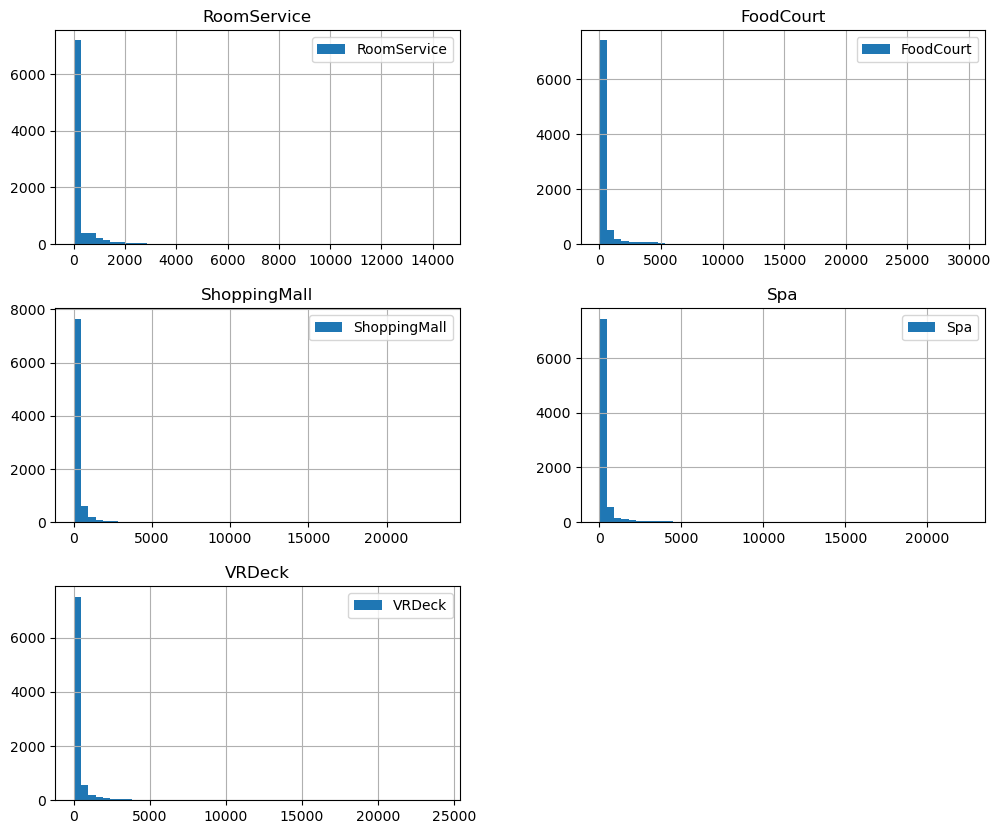

In [21]:
# Histograms for numeric variables - not normal, but mostly zero
train_df[spend_cols].hist(bins=50, figsize=(12, 10), legend=True)

plt.show()

Text(0.5, 0, 'Age (years)')

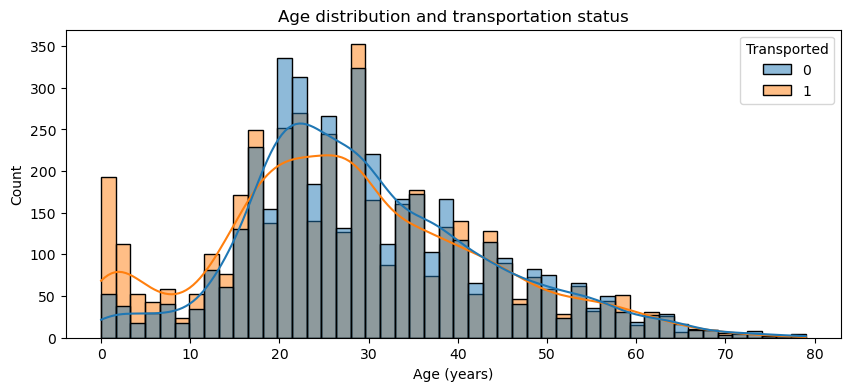

In [22]:
# Pretty similar distribution of transported versus not, used for binning
plt.figure(figsize=(10,4))

sns.histplot(train_df, x=train_df["Age"], hue="Transported", kde=True)

# Aesthetics
plt.title("Age distribution and transportation status")
plt.xlabel("Age (years)")

/var/folders/v3/vbktqv9j0y702tbl5spn92b80000gn/T/ipykernel_2374/3121090753.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


<Axes: >

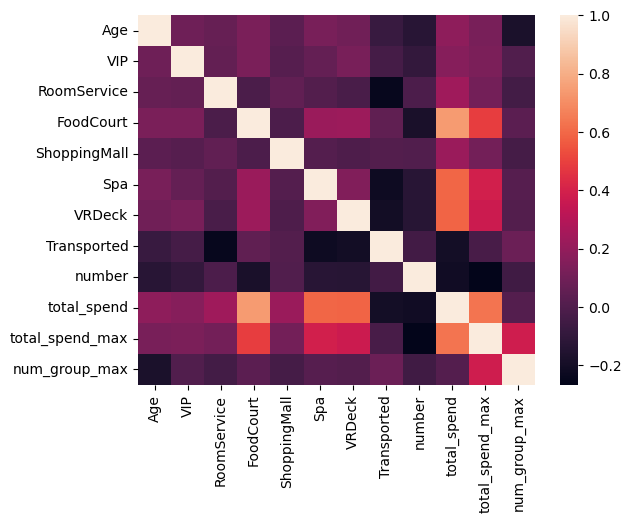

In [23]:
# Looking at data across all dimensions
corr = train_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Text(0.5, 0, 'Count of Passengers')

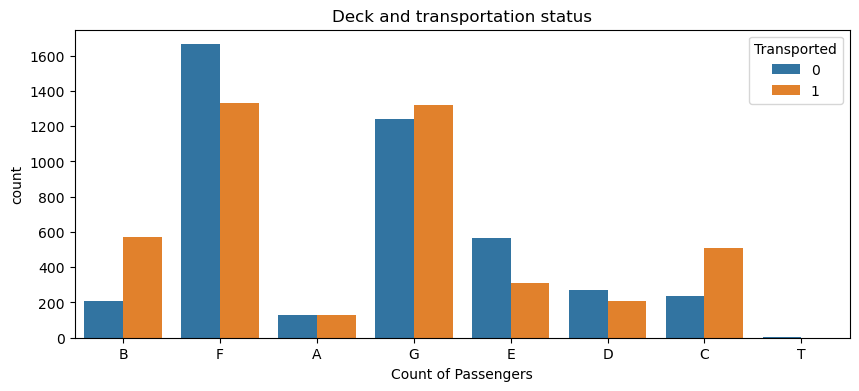

In [24]:
# Not a terrible signal...
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="deck", hue="Transported")

# Aesthetics
plt.title("Deck and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

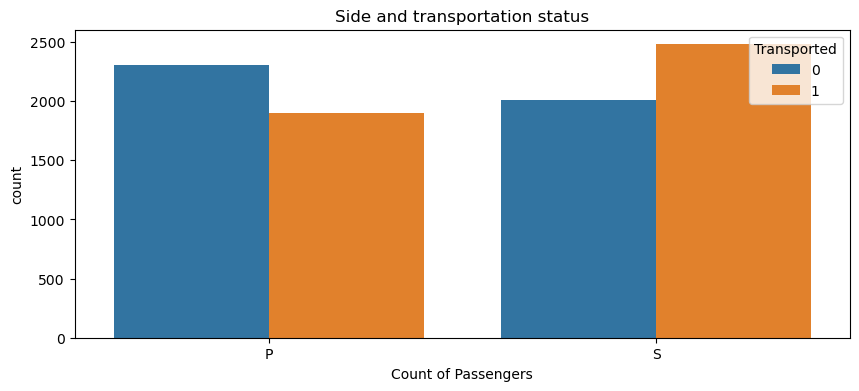

In [25]:
# Not a terrible signal...
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="side", hue="Transported")

# Aesthetics
plt.title("Side and transportation status")
plt.xlabel("Count of Passengers")

<function matplotlib.pyplot.show(close=None, block=None)>

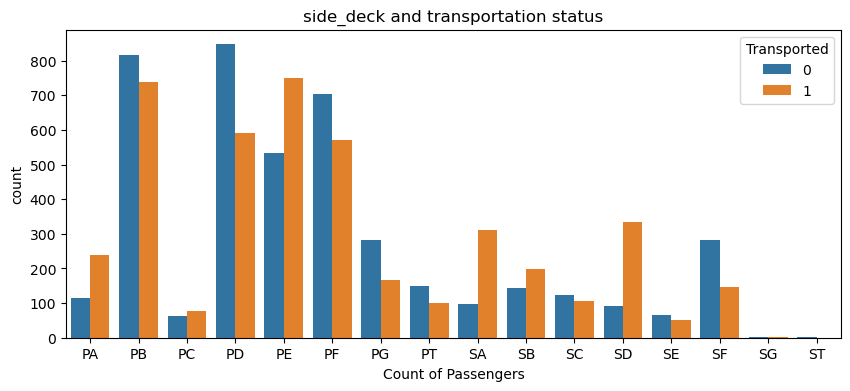

In [26]:
train_df['side_deck'] = train_df['side'] + train_df['deck']

plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="side_deck", hue="Transported")

# Aesthetics
plt.title("side_deck and transportation status")
plt.xlabel("Count of Passengers")
plt.xticks(range(len(train_df['side_deck'].sort_values().unique())),train_df['side_deck'].sort_values().unique())
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

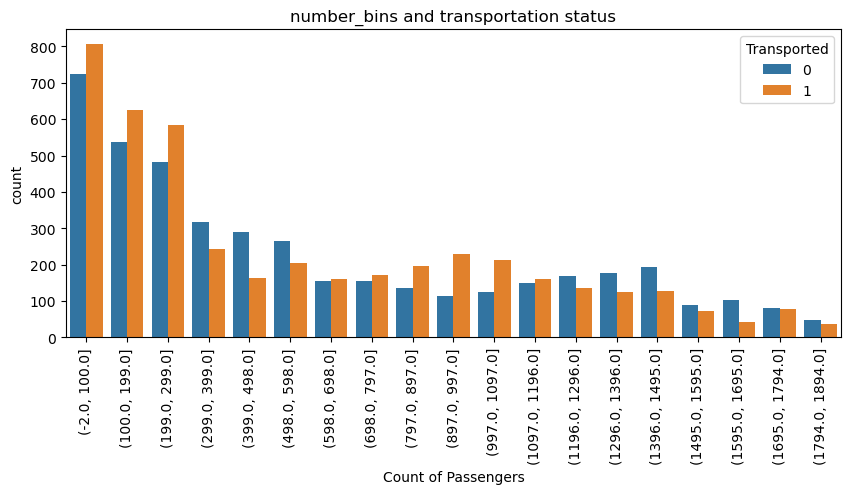

In [27]:
# Looking into issues with deck nan
# train.number.min() --0
# train.number.max() --1894

train_df['number_bins'] = pd.cut(train_df.number,19,precision=0)

plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="number_bins", hue="Transported")

# Aesthetics
plt.title("number_bins and transportation status")
plt.xlabel("Count of Passengers")
plt.xticks(range(len(train_df['number_bins'].sort_values().unique())),train_df['number_bins'].sort_values().unique(),\
          rotation=90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

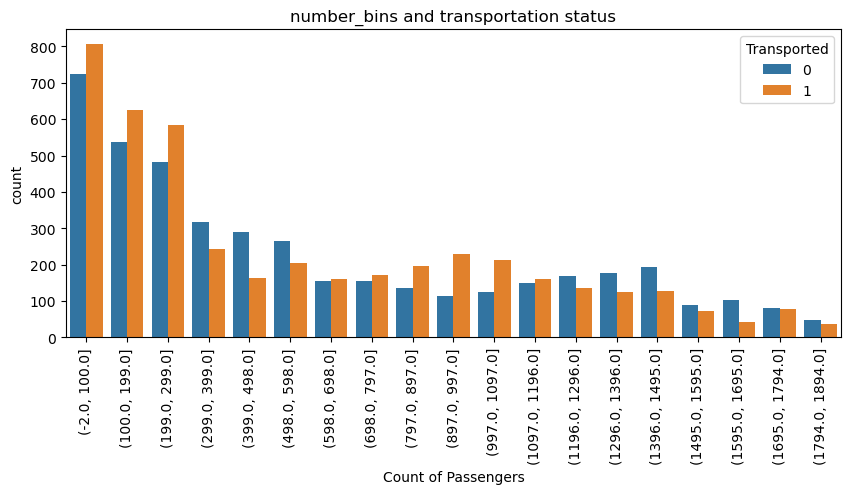

In [28]:
# Looking into issues with deck nan
# train.number.min() --0
# train.number.max() --1894

train_df['number_bins'] = pd.cut(train_df.number,19,precision=0)

plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="number_bins", hue="Transported")

# Aesthetics
plt.title("number_bins and transportation status")
plt.xlabel("Count of Passengers")
plt.xticks(range(len(train_df['number_bins'].sort_values().unique())),train_df['number_bins'].sort_values().unique(),\
          rotation=90)
plt.show

In [29]:
# Each deck has a max number of rooms...
train_df.groupby(by='deck').agg({'number':max})

,number
deck,
A,107.0
B,353.0
C,342.0
D,295.0
E,608.0
F,1894.0
G,1508.0
T,3.0


In [30]:
train_df.dropna().groupby(['passenger_group','HomePlanet','CryoSleep','Destination','VIP','deck','side','number'])\
                        .count()[['PassengerId']]\
                        .sort_values(by='PassengerId').to_csv('checking_unique_passenger_group.csv')


In [31]:
passenger_group_df = train_df.groupby(by='passenger_group').agg({'Transported':[sum,'count']})\
                    .droplevel(level=0,axis=1).reset_index()
passenger_group_df['% Trans'] = passenger_group_df['sum'] / passenger_group_df['count']

passenger_group_df

,passenger_group,sum,count,% Trans
0,0001,0,1,0.000000
1,0002,1,1,1.000000
2,0003,0,2,0.000000
3,0004,1,1,1.000000
4,0005,1,1,1.000000
...,...,...,...,...
6212,9275,2,3,0.666667
6213,9276,0,1,0.000000
6214,9278,0,1,0.000000
6215,9279,1,1,1.000000


Text(0.5, 0, 'Count of Passengers')

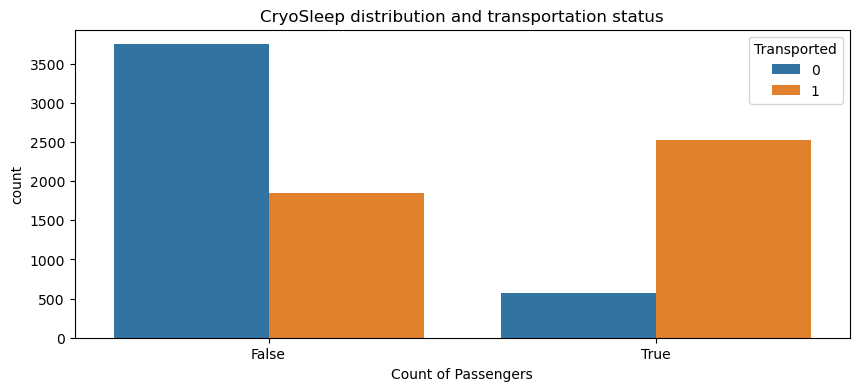

In [32]:
# Not a terrible signal...
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="CryoSleep", hue="Transported")

# Aesthetics
plt.title("CryoSleep distribution and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

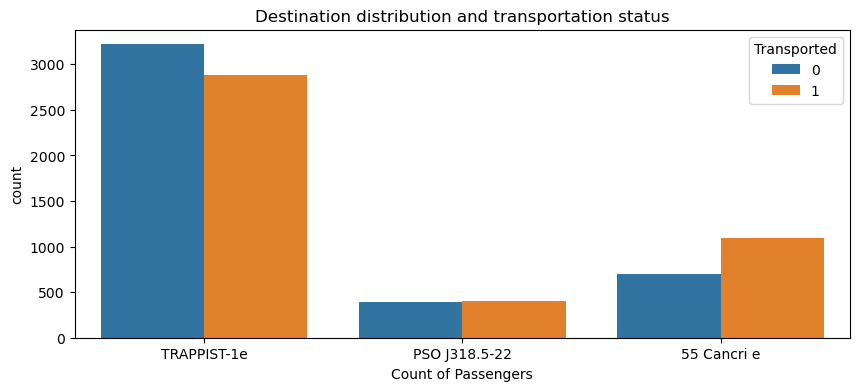

In [33]:
# Indifferent
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="Destination", hue="Transported")

# Aesthetics
plt.title("Destination distribution and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

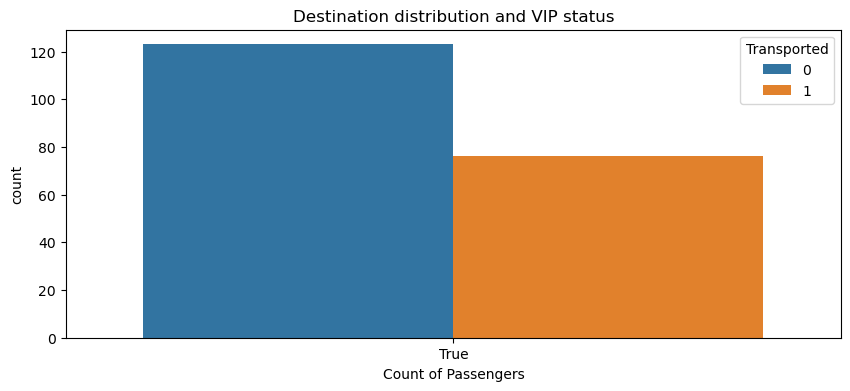

In [34]:
# Not enough people with VIP to matter
plt.figure(figsize=(10,4))

sns.countplot(data=train_df[train_df['VIP']==True], x="VIP", hue="Transported")

# Aesthetics
plt.title("Destination distribution and VIP status")
plt.xlabel("Count of Passengers")

In [35]:
# Dropping name for now, as it is too unique to use
train_df.drop('Name',axis=1,inplace=True)

Text(0.5, 0, 'Count of Passengers')

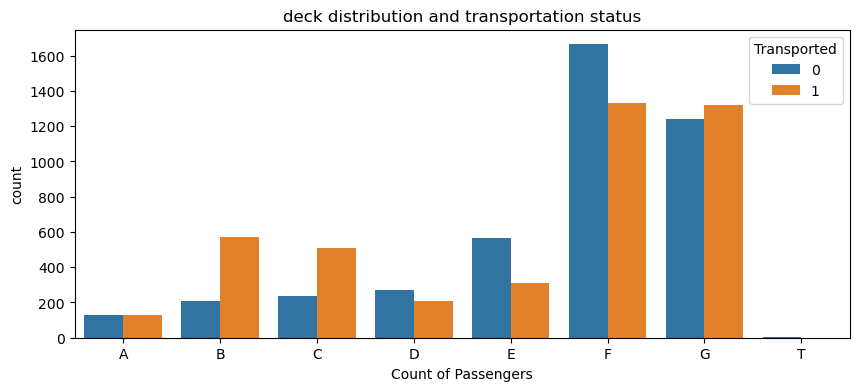

In [36]:
# Inspecting Cabin Feature Engineering....deck and cabin_type (made up names) could be good variables
plt.figure(figsize=(10,4))

sns.countplot(data=train_df.sort_values(by='deck'), x="deck", hue="Transported")

# Aesthetics
plt.title("deck distribution and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

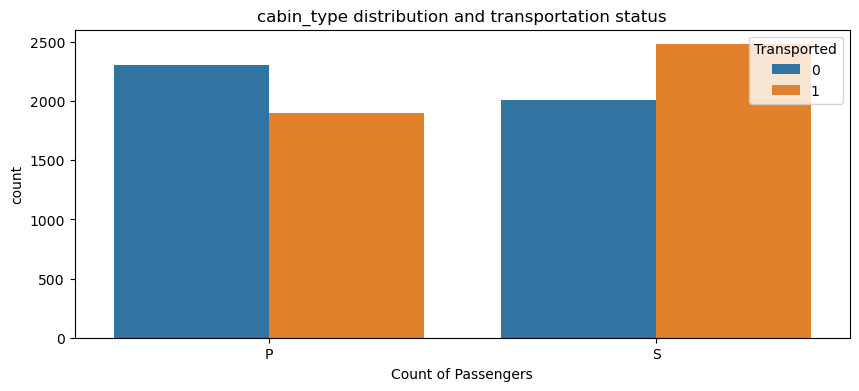

In [37]:
# Inspecting Cabin Feature Engineering....deck and cabin_type (made up names) could be good variables
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="side", hue="Transported")

# Aesthetics
plt.title("cabin_type distribution and transportation status")
plt.xlabel("Count of Passengers")

## Using Catboost Algo

In [38]:
from catboost import CatBoostClassifier, Pool

In [39]:
model = CatBoostClassifier(verbose=True)

In [40]:
object_cols.remove('num_group')
object_cols.remove('number')
object_cols

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'deck',
 'side',
 'passenger_group']

In [41]:
train_df_final = train_df[object_cols+spend_cols]

In [42]:
train_df_final.dtypes==object

HomePlanet          True
CryoSleep           True
Destination         True
VIP                False
deck                True
side                True
passenger_group     True
RoomService        False
FoodCourt          False
ShoppingMall       False
Spa                False
VRDeck             False
dtype: bool

In [43]:
object_cols

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'deck',
 'side',
 'passenger_group']

In [44]:
train_df_final.head()

,HomePlanet,CryoSleep,Destination,VIP,deck,side,passenger_group,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,TRAPPIST-1e,False,B,P,0001,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,False,F,S,0002,109.0,9.0,25.0,549.0,44.0
2,Europa,False,TRAPPIST-1e,True,A,S,0003,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,TRAPPIST-1e,False,A,S,0003,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,TRAPPIST-1e,False,F,S,0004,303.0,70.0,151.0,565.0,2.0


In [45]:
# Add cat_features to fit
model.fit(
        train_df_final
        ,train_df.Transported
        ,cat_features=object_cols)


Learning rate set to 0.025939
0:	learn: 0.6794660	total: 63.5ms	remaining: 1m 3s
1:	learn: 0.6650389	total: 69.2ms	remaining: 34.5s
2:	learn: 0.6541178	total: 74.9ms	remaining: 24.9s
3:	learn: 0.6425262	total: 81.8ms	remaining: 20.4s
4:	learn: 0.6317173	total: 87.1ms	remaining: 17.3s
5:	learn: 0.6216518	total: 92.2ms	remaining: 15.3s
6:	learn: 0.6122796	total: 98.1ms	remaining: 13.9s
7:	learn: 0.6026538	total: 103ms	remaining: 12.8s
8:	learn: 0.5951088	total: 109ms	remaining: 12s
9:	learn: 0.5867013	total: 114ms	remaining: 11.3s
10:	learn: 0.5802699	total: 119ms	remaining: 10.7s
11:	learn: 0.5723205	total: 124ms	remaining: 10.2s
12:	learn: 0.5674980	total: 129ms	remaining: 9.83s
13:	learn: 0.5613598	total: 134ms	remaining: 9.45s
14:	learn: 0.5551707	total: 139ms	remaining: 9.15s
15:	learn: 0.5500182	total: 144ms	remaining: 8.85s
16:	learn: 0.5447643	total: 149ms	remaining: 8.6s
17:	learn: 0.5430130	total: 151ms	remaining: 8.24s
18:	learn: 0.5389814	total: 157ms	remaining: 8.09s
19:	lea

169:	learn: 0.4057545	total: 997ms	remaining: 4.87s
170:	learn: 0.4056269	total: 1s	remaining: 4.87s
171:	learn: 0.4053934	total: 1.01s	remaining: 4.87s
172:	learn: 0.4052593	total: 1.02s	remaining: 4.86s
173:	learn: 0.4050887	total: 1.02s	remaining: 4.85s
174:	learn: 0.4048826	total: 1.03s	remaining: 4.84s
175:	learn: 0.4048582	total: 1.03s	remaining: 4.82s
176:	learn: 0.4047122	total: 1.04s	remaining: 4.82s
177:	learn: 0.4045396	total: 1.04s	remaining: 4.81s
178:	learn: 0.4044092	total: 1.05s	remaining: 4.8s
179:	learn: 0.4042679	total: 1.05s	remaining: 4.8s
180:	learn: 0.4040537	total: 1.06s	remaining: 4.79s
181:	learn: 0.4038348	total: 1.06s	remaining: 4.78s
182:	learn: 0.4037825	total: 1.07s	remaining: 4.77s
183:	learn: 0.4034837	total: 1.07s	remaining: 4.76s
184:	learn: 0.4032654	total: 1.08s	remaining: 4.75s
185:	learn: 0.4031834	total: 1.08s	remaining: 4.73s
186:	learn: 0.4029963	total: 1.09s	remaining: 4.73s
187:	learn: 0.4029300	total: 1.09s	remaining: 4.72s
188:	learn: 0.402

339:	learn: 0.3870127	total: 1.93s	remaining: 3.74s
340:	learn: 0.3869680	total: 1.93s	remaining: 3.73s
341:	learn: 0.3869184	total: 1.94s	remaining: 3.73s
342:	learn: 0.3868927	total: 1.94s	remaining: 3.72s
343:	learn: 0.3868460	total: 1.95s	remaining: 3.72s
344:	learn: 0.3867347	total: 1.96s	remaining: 3.72s
345:	learn: 0.3866834	total: 1.96s	remaining: 3.71s
346:	learn: 0.3865715	total: 1.97s	remaining: 3.7s
347:	learn: 0.3864924	total: 1.98s	remaining: 3.7s
348:	learn: 0.3864159	total: 1.98s	remaining: 3.69s
349:	learn: 0.3862873	total: 1.99s	remaining: 3.69s
350:	learn: 0.3861199	total: 1.99s	remaining: 3.68s
351:	learn: 0.3859948	total: 2s	remaining: 3.67s
352:	learn: 0.3859282	total: 2s	remaining: 3.67s
353:	learn: 0.3858277	total: 2.01s	remaining: 3.66s
354:	learn: 0.3857386	total: 2.01s	remaining: 3.65s
355:	learn: 0.3856744	total: 2.02s	remaining: 3.65s
356:	learn: 0.3856304	total: 2.02s	remaining: 3.64s
357:	learn: 0.3854582	total: 2.02s	remaining: 3.63s
358:	learn: 0.385439

532:	learn: 0.3717945	total: 2.93s	remaining: 2.57s
533:	learn: 0.3717714	total: 2.94s	remaining: 2.56s
534:	learn: 0.3716890	total: 2.95s	remaining: 2.56s
535:	learn: 0.3716238	total: 2.95s	remaining: 2.56s
536:	learn: 0.3715490	total: 2.96s	remaining: 2.55s
537:	learn: 0.3715278	total: 2.96s	remaining: 2.54s
538:	learn: 0.3715155	total: 2.97s	remaining: 2.54s
539:	learn: 0.3715050	total: 2.97s	remaining: 2.53s
540:	learn: 0.3714263	total: 2.98s	remaining: 2.53s
541:	learn: 0.3714122	total: 2.98s	remaining: 2.52s
542:	learn: 0.3713531	total: 2.99s	remaining: 2.51s
543:	learn: 0.3713038	total: 2.99s	remaining: 2.51s
544:	learn: 0.3712552	total: 3s	remaining: 2.5s
545:	learn: 0.3711605	total: 3s	remaining: 2.5s
546:	learn: 0.3711063	total: 3.01s	remaining: 2.49s
547:	learn: 0.3710653	total: 3.02s	remaining: 2.49s
548:	learn: 0.3710020	total: 3.02s	remaining: 2.48s
549:	learn: 0.3709558	total: 3.03s	remaining: 2.48s
550:	learn: 0.3709016	total: 3.03s	remaining: 2.47s
551:	learn: 0.370842

730:	learn: 0.3615549	total: 3.93s	remaining: 1.45s
731:	learn: 0.3614570	total: 3.94s	remaining: 1.44s
732:	learn: 0.3613834	total: 3.94s	remaining: 1.44s
733:	learn: 0.3613562	total: 3.95s	remaining: 1.43s
734:	learn: 0.3613188	total: 3.96s	remaining: 1.43s
735:	learn: 0.3612429	total: 3.96s	remaining: 1.42s
736:	learn: 0.3612023	total: 3.97s	remaining: 1.42s
737:	learn: 0.3611877	total: 3.97s	remaining: 1.41s
738:	learn: 0.3611637	total: 3.98s	remaining: 1.41s
739:	learn: 0.3610835	total: 3.98s	remaining: 1.4s
740:	learn: 0.3610335	total: 3.99s	remaining: 1.4s
741:	learn: 0.3609986	total: 4s	remaining: 1.39s
742:	learn: 0.3609805	total: 4s	remaining: 1.38s
743:	learn: 0.3609032	total: 4s	remaining: 1.38s
744:	learn: 0.3607705	total: 4.01s	remaining: 1.37s
745:	learn: 0.3606873	total: 4.01s	remaining: 1.37s
746:	learn: 0.3606658	total: 4.02s	remaining: 1.36s
747:	learn: 0.3606021	total: 4.03s	remaining: 1.36s
748:	learn: 0.3605190	total: 4.03s	remaining: 1.35s
749:	learn: 0.3604533	t

920:	learn: 0.3524650	total: 4.93s	remaining: 423ms
921:	learn: 0.3524504	total: 4.93s	remaining: 417ms
922:	learn: 0.3523912	total: 4.94s	remaining: 412ms
923:	learn: 0.3523756	total: 4.94s	remaining: 407ms
924:	learn: 0.3522959	total: 4.95s	remaining: 401ms
925:	learn: 0.3522175	total: 4.95s	remaining: 396ms
926:	learn: 0.3520709	total: 4.96s	remaining: 391ms
927:	learn: 0.3520638	total: 4.96s	remaining: 385ms
928:	learn: 0.3520584	total: 4.97s	remaining: 380ms
929:	learn: 0.3520499	total: 4.98s	remaining: 375ms
930:	learn: 0.3519734	total: 4.98s	remaining: 369ms
931:	learn: 0.3518518	total: 4.99s	remaining: 364ms
932:	learn: 0.3518097	total: 4.99s	remaining: 359ms
933:	learn: 0.3517662	total: 5s	remaining: 353ms
934:	learn: 0.3517480	total: 5s	remaining: 348ms
935:	learn: 0.3516762	total: 5.01s	remaining: 342ms
936:	learn: 0.3516752	total: 5.01s	remaining: 337ms
937:	learn: 0.3515924	total: 5.02s	remaining: 332ms
938:	learn: 0.3515306	total: 5.02s	remaining: 326ms
939:	learn: 0.3515

In [46]:
test_df_final = test_df[object_cols+spend_cols]

In [47]:
test_df_final

,HomePlanet,CryoSleep,Destination,VIP,deck,side,passenger_group,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,TRAPPIST-1e,False,G,S,0013,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,False,F,S,0018,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,55 Cancri e,False,C,S,0019,0.0,0.0,0.0,0.0,0.0
3,Europa,False,TRAPPIST-1e,False,C,S,0021,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,TRAPPIST-1e,False,F,S,0023,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,False,G,S,9266,0.0,0.0,0.0,0.0,0.0
4273,Earth,False,TRAPPIST-1e,False,F,S,9269,0.0,847.0,17.0,10.0,144.0
4274,Mars,True,55 Cancri e,False,D,P,9271,0.0,0.0,0.0,0.0,0.0
4275,Europa,False,TRAPPIST-1e,False,D,P,9273,0.0,2680.0,0.0,0.0,523.0


In [48]:
preds_class = model.predict(test_df_final)
preds_class

array([1, 0, 1, ..., 1, 1, 1])

In [49]:
pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('catboost_submission.csv',index=False)

# Score: 0.80313

In [54]:
parameters = {'iterations':(10,50,100,200), 'depth':[2,5,10,20,50],'learning_rate':[.25,.1,.01]}
algo = CatBoostClassifier()

model_gs = GridSearchCV(algo,parameters,verbose=True)

model_gs.fit(train_df_final
        ,train_df.Transported
        ,cat_features=object_cols)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
0:	learn: 0.6422891	total: 2.02ms	remaining: 18.2ms
1:	learn: 0.6096598	total: 3.73ms	remaining: 14.9ms
2:	learn: 0.5871305	total: 5.43ms	remaining: 12.7ms
3:	learn: 0.5703837	total: 7.59ms	remaining: 11.4ms
4:	learn: 0.5547204	total: 11ms	remaining: 11ms
5:	learn: 0.5404631	total: 12.9ms	remaining: 8.63ms
6:	learn: 0.5300812	total: 14.8ms	remaining: 6.34ms
7:	learn: 0.5202839	total: 16.6ms	remaining: 4.15ms
8:	learn: 0.5133513	total: 18.3ms	remaining: 2.04ms
9:	learn: 0.5069943	total: 20.2ms	remaining: 0us
0:	learn: 0.6425002	total: 1.13ms	remaining: 10.2ms
1:	learn: 0.6097807	total: 2.2ms	remaining: 8.8ms
2:	learn: 0.5875900	total: 3.27ms	remaining: 7.63ms
3:	learn: 0.5733908	total: 4.26ms	remaining: 6.38ms
4:	learn: 0.5552791	total: 5.1ms	remaining: 5.1ms
5:	learn: 0.5433056	total: 6.04ms	remaining: 4.03ms
6:	learn: 0.5320185	total: 7.02ms	remaining: 3.01ms
7:	learn: 0.5226571	total: 7.94ms	remaining: 1.99ms
8:	learn: 0.5

16:	learn: 0.4784949	total: 16.6ms	remaining: 32.3ms
17:	learn: 0.4754681	total: 17.8ms	remaining: 31.6ms
18:	learn: 0.4722834	total: 18.7ms	remaining: 30.6ms
19:	learn: 0.4697066	total: 19.7ms	remaining: 29.5ms
20:	learn: 0.4678290	total: 20.7ms	remaining: 28.6ms
21:	learn: 0.4636812	total: 21.6ms	remaining: 27.5ms
22:	learn: 0.4611503	total: 22.6ms	remaining: 26.5ms
23:	learn: 0.4591124	total: 23.7ms	remaining: 25.7ms
24:	learn: 0.4576268	total: 24.7ms	remaining: 24.7ms
25:	learn: 0.4560723	total: 25.8ms	remaining: 23.8ms
26:	learn: 0.4541270	total: 26.7ms	remaining: 22.8ms
27:	learn: 0.4528974	total: 27.8ms	remaining: 21.9ms
28:	learn: 0.4517835	total: 29ms	remaining: 21ms
29:	learn: 0.4502533	total: 30.1ms	remaining: 20.1ms
30:	learn: 0.4485297	total: 31.1ms	remaining: 19.1ms
31:	learn: 0.4475705	total: 32.1ms	remaining: 18.1ms
32:	learn: 0.4457273	total: 33.3ms	remaining: 17.1ms
33:	learn: 0.4437232	total: 34.3ms	remaining: 16.1ms
34:	learn: 0.4423877	total: 35.2ms	remaining: 15.1

0:	learn: 0.6711710	total: 1.45ms	remaining: 71.1ms
1:	learn: 0.6522007	total: 2.55ms	remaining: 61.2ms
2:	learn: 0.6368640	total: 3.96ms	remaining: 62.1ms
3:	learn: 0.6239796	total: 5.08ms	remaining: 58.4ms
4:	learn: 0.6122827	total: 6.13ms	remaining: 55.2ms
5:	learn: 0.6020850	total: 7.74ms	remaining: 56.7ms
6:	learn: 0.5917663	total: 8.71ms	remaining: 53.5ms
7:	learn: 0.5842927	total: 9.68ms	remaining: 50.8ms
8:	learn: 0.5781744	total: 10.6ms	remaining: 48.5ms
9:	learn: 0.5704640	total: 11.6ms	remaining: 46.3ms
10:	learn: 0.5646159	total: 12.4ms	remaining: 44.1ms
11:	learn: 0.5587342	total: 13.4ms	remaining: 42.3ms
12:	learn: 0.5521969	total: 14.4ms	remaining: 40.9ms
13:	learn: 0.5466413	total: 15.2ms	remaining: 39.2ms
14:	learn: 0.5426389	total: 16.1ms	remaining: 37.5ms
15:	learn: 0.5386220	total: 17.2ms	remaining: 36.6ms
16:	learn: 0.5338994	total: 18.1ms	remaining: 35.1ms
17:	learn: 0.5301713	total: 19ms	remaining: 33.8ms
18:	learn: 0.5265959	total: 19.9ms	remaining: 32.5ms
19:	l

0:	learn: 0.6908461	total: 1.11ms	remaining: 54.4ms
1:	learn: 0.6885017	total: 2.18ms	remaining: 52.3ms
2:	learn: 0.6862425	total: 3.32ms	remaining: 52ms
3:	learn: 0.6840553	total: 4.39ms	remaining: 50.4ms
4:	learn: 0.6817821	total: 5.21ms	remaining: 46.9ms
5:	learn: 0.6796764	total: 6.09ms	remaining: 44.7ms
6:	learn: 0.6775426	total: 6.9ms	remaining: 42.4ms
7:	learn: 0.6753936	total: 7.83ms	remaining: 41.1ms
8:	learn: 0.6733900	total: 8.64ms	remaining: 39.4ms
9:	learn: 0.6714328	total: 9.54ms	remaining: 38.2ms
10:	learn: 0.6695359	total: 10.4ms	remaining: 36.8ms
11:	learn: 0.6675968	total: 11.3ms	remaining: 35.6ms
12:	learn: 0.6656283	total: 12ms	remaining: 34.3ms
13:	learn: 0.6637056	total: 12.8ms	remaining: 33ms
14:	learn: 0.6619142	total: 13.6ms	remaining: 31.8ms
15:	learn: 0.6602220	total: 14.4ms	remaining: 30.7ms
16:	learn: 0.6583754	total: 15.2ms	remaining: 29.6ms
17:	learn: 0.6567856	total: 16ms	remaining: 28.5ms
18:	learn: 0.6550912	total: 16.9ms	remaining: 27.6ms
19:	learn: 0

52:	learn: 0.4265779	total: 54.6ms	remaining: 48.4ms
53:	learn: 0.4252564	total: 55.9ms	remaining: 47.6ms
54:	learn: 0.4248516	total: 56.9ms	remaining: 46.6ms
55:	learn: 0.4246143	total: 58ms	remaining: 45.6ms
56:	learn: 0.4239857	total: 59ms	remaining: 44.5ms
57:	learn: 0.4236285	total: 60ms	remaining: 43.4ms
58:	learn: 0.4231094	total: 60.9ms	remaining: 42.3ms
59:	learn: 0.4226310	total: 61.9ms	remaining: 41.3ms
60:	learn: 0.4221216	total: 63ms	remaining: 40.3ms
61:	learn: 0.4218309	total: 64.3ms	remaining: 39.4ms
62:	learn: 0.4217063	total: 65.3ms	remaining: 38.4ms
63:	learn: 0.4216968	total: 66.5ms	remaining: 37.4ms
64:	learn: 0.4215223	total: 67.7ms	remaining: 36.5ms
65:	learn: 0.4212980	total: 68.7ms	remaining: 35.4ms
66:	learn: 0.4210791	total: 69.6ms	remaining: 34.3ms
67:	learn: 0.4206260	total: 70.6ms	remaining: 33.2ms
68:	learn: 0.4205127	total: 71.9ms	remaining: 32.3ms
69:	learn: 0.4202448	total: 73.1ms	remaining: 31.3ms
70:	learn: 0.4200530	total: 74.1ms	remaining: 30.3ms
7

53:	learn: 0.4294727	total: 54.3ms	remaining: 46.3ms
54:	learn: 0.4288039	total: 55.5ms	remaining: 45.4ms
55:	learn: 0.4285627	total: 56.6ms	remaining: 44.4ms
56:	learn: 0.4285362	total: 57.5ms	remaining: 43.4ms
57:	learn: 0.4280645	total: 58.5ms	remaining: 42.3ms
58:	learn: 0.4276350	total: 59.4ms	remaining: 41.3ms
59:	learn: 0.4271257	total: 60.5ms	remaining: 40.4ms
60:	learn: 0.4268957	total: 61.6ms	remaining: 39.4ms
61:	learn: 0.4265490	total: 62.5ms	remaining: 38.3ms
62:	learn: 0.4261332	total: 63.5ms	remaining: 37.3ms
63:	learn: 0.4258833	total: 64.5ms	remaining: 36.3ms
64:	learn: 0.4252765	total: 65.7ms	remaining: 35.4ms
65:	learn: 0.4250695	total: 66.7ms	remaining: 34.4ms
66:	learn: 0.4243343	total: 67.8ms	remaining: 33.4ms
67:	learn: 0.4242435	total: 69.3ms	remaining: 32.6ms
68:	learn: 0.4242402	total: 70.3ms	remaining: 31.6ms
69:	learn: 0.4240198	total: 71.2ms	remaining: 30.5ms
70:	learn: 0.4236989	total: 72.2ms	remaining: 29.5ms
71:	learn: 0.4234313	total: 73.3ms	remaining: 

49:	learn: 0.4698491	total: 47.9ms	remaining: 47.9ms
50:	learn: 0.4691743	total: 48.9ms	remaining: 47ms
51:	learn: 0.4681510	total: 50ms	remaining: 46.2ms
52:	learn: 0.4672545	total: 51ms	remaining: 45.2ms
53:	learn: 0.4663230	total: 52ms	remaining: 44.3ms
54:	learn: 0.4652234	total: 53ms	remaining: 43.4ms
55:	learn: 0.4644563	total: 54ms	remaining: 42.4ms
56:	learn: 0.4633838	total: 54.9ms	remaining: 41.4ms
57:	learn: 0.4627159	total: 55.9ms	remaining: 40.5ms
58:	learn: 0.4618684	total: 56.8ms	remaining: 39.5ms
59:	learn: 0.4609145	total: 57.9ms	remaining: 38.6ms
60:	learn: 0.4603503	total: 58.9ms	remaining: 37.6ms
61:	learn: 0.4595890	total: 59.9ms	remaining: 36.7ms
62:	learn: 0.4588985	total: 61ms	remaining: 35.9ms
63:	learn: 0.4582964	total: 62.2ms	remaining: 35ms
64:	learn: 0.4578718	total: 63.3ms	remaining: 34.1ms
65:	learn: 0.4573294	total: 64.3ms	remaining: 33.1ms
66:	learn: 0.4567336	total: 65.3ms	remaining: 32.2ms
67:	learn: 0.4559932	total: 66.3ms	remaining: 31.2ms
68:	learn

37:	learn: 0.4901758	total: 41.7ms	remaining: 68ms
38:	learn: 0.4887494	total: 43ms	remaining: 67.2ms
39:	learn: 0.4879212	total: 43.9ms	remaining: 65.9ms
40:	learn: 0.4865789	total: 44.9ms	remaining: 64.6ms
41:	learn: 0.4851894	total: 45.8ms	remaining: 63.2ms
42:	learn: 0.4836710	total: 47ms	remaining: 62.2ms
43:	learn: 0.4825672	total: 48.5ms	remaining: 61.7ms
44:	learn: 0.4812179	total: 50.5ms	remaining: 61.7ms
45:	learn: 0.4800969	total: 52ms	remaining: 61.1ms
46:	learn: 0.4789548	total: 53.1ms	remaining: 59.9ms
47:	learn: 0.4779205	total: 54.1ms	remaining: 58.6ms
48:	learn: 0.4771076	total: 55.1ms	remaining: 57.3ms
49:	learn: 0.4758844	total: 56.1ms	remaining: 56.1ms
50:	learn: 0.4751344	total: 57.1ms	remaining: 54.9ms
51:	learn: 0.4741896	total: 58.3ms	remaining: 53.8ms
52:	learn: 0.4732770	total: 59.7ms	remaining: 52.9ms
53:	learn: 0.4724443	total: 60.9ms	remaining: 51.9ms
54:	learn: 0.4715206	total: 61.8ms	remaining: 50.6ms
55:	learn: 0.4704426	total: 63.3ms	remaining: 49.7ms
5

4:	learn: 0.6813760	total: 5.37ms	remaining: 102ms
5:	learn: 0.6791422	total: 6.41ms	remaining: 100ms
6:	learn: 0.6769513	total: 7.33ms	remaining: 97.4ms
7:	learn: 0.6747667	total: 8.54ms	remaining: 98.2ms
8:	learn: 0.6726587	total: 9.87ms	remaining: 99.8ms
9:	learn: 0.6707850	total: 11.2ms	remaining: 101ms
10:	learn: 0.6687506	total: 12.3ms	remaining: 99.6ms
11:	learn: 0.6667832	total: 13.3ms	remaining: 97.9ms
12:	learn: 0.6648314	total: 15.9ms	remaining: 106ms
13:	learn: 0.6629107	total: 17.1ms	remaining: 105ms
14:	learn: 0.6610641	total: 18.1ms	remaining: 102ms
15:	learn: 0.6593769	total: 19.6ms	remaining: 103ms
16:	learn: 0.6575070	total: 20.7ms	remaining: 101ms
17:	learn: 0.6557444	total: 21.7ms	remaining: 98.6ms
18:	learn: 0.6540710	total: 22.5ms	remaining: 96.1ms
19:	learn: 0.6523384	total: 23.5ms	remaining: 94.1ms
20:	learn: 0.6505869	total: 25.1ms	remaining: 94.6ms
21:	learn: 0.6489176	total: 27.3ms	remaining: 96.7ms
22:	learn: 0.6473070	total: 28.5ms	remaining: 95.5ms
23:	lea

38:	learn: 0.6270942	total: 94.2ms	remaining: 147ms
39:	learn: 0.6258793	total: 98ms	remaining: 147ms
40:	learn: 0.6247481	total: 99.5ms	remaining: 143ms
41:	learn: 0.6235998	total: 101ms	remaining: 139ms
42:	learn: 0.6224418	total: 102ms	remaining: 135ms
43:	learn: 0.6213469	total: 103ms	remaining: 131ms
44:	learn: 0.6202290	total: 104ms	remaining: 127ms
45:	learn: 0.6191262	total: 104ms	remaining: 123ms
46:	learn: 0.6180432	total: 106ms	remaining: 119ms
47:	learn: 0.6169559	total: 107ms	remaining: 116ms
48:	learn: 0.6159081	total: 108ms	remaining: 112ms
49:	learn: 0.6148717	total: 109ms	remaining: 109ms
50:	learn: 0.6138331	total: 110ms	remaining: 106ms
51:	learn: 0.6128835	total: 113ms	remaining: 104ms
52:	learn: 0.6118799	total: 114ms	remaining: 101ms
53:	learn: 0.6109420	total: 116ms	remaining: 98.7ms
54:	learn: 0.6099711	total: 117ms	remaining: 95.6ms
55:	learn: 0.6090190	total: 118ms	remaining: 92.7ms
56:	learn: 0.6080827	total: 119ms	remaining: 89.6ms
57:	learn: 0.6072181	total

120:	learn: 0.3985286	total: 400ms	remaining: 261ms
121:	learn: 0.3984451	total: 403ms	remaining: 257ms
122:	learn: 0.3979290	total: 407ms	remaining: 255ms
123:	learn: 0.3977480	total: 410ms	remaining: 251ms
124:	learn: 0.3974995	total: 416ms	remaining: 249ms
125:	learn: 0.3972641	total: 434ms	remaining: 255ms
126:	learn: 0.3971724	total: 457ms	remaining: 263ms
127:	learn: 0.3970559	total: 466ms	remaining: 262ms
128:	learn: 0.3970005	total: 470ms	remaining: 259ms
129:	learn: 0.3967308	total: 473ms	remaining: 255ms
130:	learn: 0.3965459	total: 477ms	remaining: 251ms
131:	learn: 0.3963268	total: 483ms	remaining: 249ms
132:	learn: 0.3962103	total: 485ms	remaining: 244ms
133:	learn: 0.3958029	total: 488ms	remaining: 240ms
134:	learn: 0.3958005	total: 491ms	remaining: 237ms
135:	learn: 0.3955787	total: 496ms	remaining: 233ms
136:	learn: 0.3950584	total: 498ms	remaining: 229ms
137:	learn: 0.3949021	total: 502ms	remaining: 226ms
138:	learn: 0.3948992	total: 505ms	remaining: 222ms
139:	learn: 

85:	learn: 0.4055231	total: 222ms	remaining: 295ms
86:	learn: 0.4053577	total: 225ms	remaining: 292ms
87:	learn: 0.4050967	total: 227ms	remaining: 289ms
88:	learn: 0.4050084	total: 230ms	remaining: 287ms
89:	learn: 0.4045397	total: 232ms	remaining: 283ms
90:	learn: 0.4042973	total: 234ms	remaining: 280ms
91:	learn: 0.4041613	total: 236ms	remaining: 277ms
92:	learn: 0.4039615	total: 239ms	remaining: 275ms
93:	learn: 0.4038158	total: 242ms	remaining: 273ms
94:	learn: 0.4035795	total: 244ms	remaining: 270ms
95:	learn: 0.4034701	total: 247ms	remaining: 267ms
96:	learn: 0.4032079	total: 249ms	remaining: 265ms
97:	learn: 0.4026246	total: 252ms	remaining: 262ms
98:	learn: 0.4023851	total: 254ms	remaining: 259ms
99:	learn: 0.4020125	total: 257ms	remaining: 257ms
100:	learn: 0.4018046	total: 259ms	remaining: 254ms
101:	learn: 0.4015795	total: 261ms	remaining: 251ms
102:	learn: 0.4015749	total: 264ms	remaining: 249ms
103:	learn: 0.4014752	total: 266ms	remaining: 245ms
104:	learn: 0.4013263	total

48:	learn: 0.4229579	total: 200ms	remaining: 615ms
49:	learn: 0.4221695	total: 204ms	remaining: 612ms
50:	learn: 0.4217577	total: 208ms	remaining: 607ms
51:	learn: 0.4212577	total: 212ms	remaining: 603ms
52:	learn: 0.4198927	total: 216ms	remaining: 598ms
53:	learn: 0.4195838	total: 221ms	remaining: 598ms
54:	learn: 0.4187836	total: 225ms	remaining: 592ms
55:	learn: 0.4184338	total: 228ms	remaining: 586ms
56:	learn: 0.4179417	total: 232ms	remaining: 582ms
57:	learn: 0.4174901	total: 237ms	remaining: 579ms
58:	learn: 0.4166787	total: 243ms	remaining: 580ms
59:	learn: 0.4161585	total: 249ms	remaining: 582ms
60:	learn: 0.4157026	total: 255ms	remaining: 582ms
61:	learn: 0.4155923	total: 261ms	remaining: 580ms
62:	learn: 0.4152826	total: 265ms	remaining: 576ms
63:	learn: 0.4146179	total: 269ms	remaining: 573ms
64:	learn: 0.4144843	total: 273ms	remaining: 568ms
65:	learn: 0.4140465	total: 278ms	remaining: 564ms
66:	learn: 0.4137256	total: 282ms	remaining: 560ms
67:	learn: 0.4132519	total: 285

52:	learn: 0.4196061	total: 214ms	remaining: 593ms
53:	learn: 0.4191853	total: 220ms	remaining: 595ms
54:	learn: 0.4186688	total: 224ms	remaining: 591ms
55:	learn: 0.4184407	total: 229ms	remaining: 588ms
56:	learn: 0.4182681	total: 236ms	remaining: 592ms
57:	learn: 0.4178757	total: 240ms	remaining: 587ms
58:	learn: 0.4175134	total: 244ms	remaining: 584ms
59:	learn: 0.4171745	total: 250ms	remaining: 584ms
60:	learn: 0.4167239	total: 256ms	remaining: 582ms
61:	learn: 0.4167238	total: 258ms	remaining: 575ms
62:	learn: 0.4163389	total: 261ms	remaining: 567ms
63:	learn: 0.4162458	total: 266ms	remaining: 565ms
64:	learn: 0.4158017	total: 271ms	remaining: 562ms
65:	learn: 0.4154842	total: 273ms	remaining: 554ms
66:	learn: 0.4154549	total: 275ms	remaining: 546ms
67:	learn: 0.4147636	total: 278ms	remaining: 539ms
68:	learn: 0.4145749	total: 284ms	remaining: 540ms
69:	learn: 0.4143662	total: 287ms	remaining: 533ms
70:	learn: 0.4143406	total: 290ms	remaining: 526ms
71:	learn: 0.4143401	total: 292

50:	learn: 0.4232832	total: 200ms	remaining: 584ms
51:	learn: 0.4229714	total: 203ms	remaining: 578ms
52:	learn: 0.4222165	total: 205ms	remaining: 568ms
53:	learn: 0.4216341	total: 208ms	remaining: 563ms
54:	learn: 0.4213660	total: 212ms	remaining: 558ms
55:	learn: 0.4210712	total: 215ms	remaining: 553ms
56:	learn: 0.4208254	total: 218ms	remaining: 546ms
57:	learn: 0.4207986	total: 221ms	remaining: 542ms
58:	learn: 0.4206453	total: 225ms	remaining: 538ms
59:	learn: 0.4202307	total: 229ms	remaining: 534ms
60:	learn: 0.4195640	total: 232ms	remaining: 529ms
61:	learn: 0.4191130	total: 234ms	remaining: 522ms
62:	learn: 0.4189288	total: 237ms	remaining: 516ms
63:	learn: 0.4188290	total: 241ms	remaining: 511ms
64:	learn: 0.4179809	total: 243ms	remaining: 505ms
65:	learn: 0.4177998	total: 246ms	remaining: 499ms
66:	learn: 0.4176139	total: 248ms	remaining: 492ms
67:	learn: 0.4174598	total: 251ms	remaining: 486ms
68:	learn: 0.4173432	total: 253ms	remaining: 480ms
69:	learn: 0.4171712	total: 255

21:	learn: 0.4963683	total: 55ms	remaining: 445ms
22:	learn: 0.4935950	total: 59.1ms	remaining: 455ms
23:	learn: 0.4908861	total: 62.4ms	remaining: 458ms
24:	learn: 0.4890566	total: 65.6ms	remaining: 459ms
25:	learn: 0.4865077	total: 68.1ms	remaining: 456ms
26:	learn: 0.4840131	total: 71.2ms	remaining: 456ms
27:	learn: 0.4820729	total: 74.6ms	remaining: 458ms
28:	learn: 0.4800761	total: 78.8ms	remaining: 465ms
29:	learn: 0.4785683	total: 81.8ms	remaining: 464ms
30:	learn: 0.4772531	total: 84ms	remaining: 458ms
31:	learn: 0.4760280	total: 86.3ms	remaining: 453ms
32:	learn: 0.4745931	total: 88.6ms	remaining: 448ms
33:	learn: 0.4734669	total: 92.2ms	remaining: 450ms
34:	learn: 0.4715024	total: 95.1ms	remaining: 449ms
35:	learn: 0.4702215	total: 97.7ms	remaining: 445ms
36:	learn: 0.4692640	total: 99.9ms	remaining: 440ms
37:	learn: 0.4676995	total: 102ms	remaining: 437ms
38:	learn: 0.4666555	total: 105ms	remaining: 433ms
39:	learn: 0.4650651	total: 108ms	remaining: 433ms
40:	learn: 0.464038

25:	learn: 0.4907792	total: 69.3ms	remaining: 464ms
26:	learn: 0.4881590	total: 71.7ms	remaining: 460ms
27:	learn: 0.4859805	total: 74.5ms	remaining: 457ms
28:	learn: 0.4844698	total: 78.4ms	remaining: 462ms
29:	learn: 0.4828171	total: 81.1ms	remaining: 459ms
30:	learn: 0.4806473	total: 83.7ms	remaining: 456ms
31:	learn: 0.4788999	total: 85.9ms	remaining: 451ms
32:	learn: 0.4774205	total: 88.5ms	remaining: 448ms
33:	learn: 0.4760428	total: 90.8ms	remaining: 443ms
34:	learn: 0.4746449	total: 94.3ms	remaining: 445ms
35:	learn: 0.4733337	total: 98.3ms	remaining: 448ms
36:	learn: 0.4720321	total: 101ms	remaining: 443ms
37:	learn: 0.4707500	total: 103ms	remaining: 439ms
38:	learn: 0.4696222	total: 105ms	remaining: 434ms
39:	learn: 0.4682792	total: 108ms	remaining: 431ms
40:	learn: 0.4670922	total: 111ms	remaining: 430ms
41:	learn: 0.4654614	total: 113ms	remaining: 427ms
42:	learn: 0.4648158	total: 115ms	remaining: 422ms
43:	learn: 0.4631457	total: 118ms	remaining: 418ms
44:	learn: 0.4611816

35:	learn: 0.4687890	total: 93.3ms	remaining: 425ms
36:	learn: 0.4674023	total: 97.8ms	remaining: 431ms
37:	learn: 0.4666213	total: 101ms	remaining: 430ms
38:	learn: 0.4657069	total: 107ms	remaining: 441ms
39:	learn: 0.4647553	total: 111ms	remaining: 445ms
40:	learn: 0.4635541	total: 115ms	remaining: 444ms
41:	learn: 0.4620803	total: 118ms	remaining: 443ms
42:	learn: 0.4601021	total: 121ms	remaining: 441ms
43:	learn: 0.4594020	total: 123ms	remaining: 437ms
44:	learn: 0.4584311	total: 126ms	remaining: 433ms
45:	learn: 0.4579432	total: 129ms	remaining: 431ms
46:	learn: 0.4571593	total: 132ms	remaining: 429ms
47:	learn: 0.4564730	total: 135ms	remaining: 427ms
48:	learn: 0.4553009	total: 137ms	remaining: 423ms
49:	learn: 0.4545581	total: 140ms	remaining: 419ms
50:	learn: 0.4532094	total: 142ms	remaining: 416ms
51:	learn: 0.4522987	total: 145ms	remaining: 414ms
52:	learn: 0.4515824	total: 148ms	remaining: 411ms
53:	learn: 0.4507642	total: 150ms	remaining: 406ms
54:	learn: 0.4503933	total: 1

28:	learn: 0.4822141	total: 114ms	remaining: 675ms
29:	learn: 0.4809476	total: 118ms	remaining: 667ms
30:	learn: 0.4794047	total: 147ms	remaining: 802ms
31:	learn: 0.4778218	total: 150ms	remaining: 785ms
32:	learn: 0.4760910	total: 152ms	remaining: 772ms
33:	learn: 0.4733229	total: 158ms	remaining: 770ms
34:	learn: 0.4721779	total: 160ms	remaining: 756ms
35:	learn: 0.4712702	total: 163ms	remaining: 743ms
36:	learn: 0.4700507	total: 168ms	remaining: 740ms
37:	learn: 0.4689067	total: 186ms	remaining: 795ms
38:	learn: 0.4678157	total: 192ms	remaining: 793ms
39:	learn: 0.4664719	total: 203ms	remaining: 811ms
40:	learn: 0.4654800	total: 208ms	remaining: 805ms
41:	learn: 0.4642075	total: 210ms	remaining: 791ms
42:	learn: 0.4631947	total: 212ms	remaining: 776ms
43:	learn: 0.4622411	total: 216ms	remaining: 765ms
44:	learn: 0.4616361	total: 218ms	remaining: 751ms
45:	learn: 0.4601930	total: 221ms	remaining: 740ms
46:	learn: 0.4589346	total: 223ms	remaining: 727ms
47:	learn: 0.4581539	total: 226

0:	learn: 0.6575473	total: 6.3ms	remaining: 1.25s
1:	learn: 0.6342144	total: 10.6ms	remaining: 1.05s
2:	learn: 0.6200779	total: 14.6ms	remaining: 959ms
3:	learn: 0.6084265	total: 21.7ms	remaining: 1.06s
4:	learn: 0.5990934	total: 24.1ms	remaining: 939ms
5:	learn: 0.5855385	total: 33.3ms	remaining: 1.08s
6:	learn: 0.5742612	total: 38.4ms	remaining: 1.06s
7:	learn: 0.5679688	total: 41.7ms	remaining: 1s
8:	learn: 0.5597626	total: 47.8ms	remaining: 1.01s
9:	learn: 0.5539606	total: 60.9ms	remaining: 1.16s
10:	learn: 0.5470530	total: 67.3ms	remaining: 1.16s
11:	learn: 0.5415718	total: 72.4ms	remaining: 1.13s
12:	learn: 0.5370460	total: 83.2ms	remaining: 1.2s
13:	learn: 0.5323310	total: 87.5ms	remaining: 1.16s
14:	learn: 0.5273759	total: 92.1ms	remaining: 1.14s
15:	learn: 0.5241433	total: 96.3ms	remaining: 1.11s
16:	learn: 0.5206992	total: 102ms	remaining: 1.1s
17:	learn: 0.5177270	total: 107ms	remaining: 1.08s
18:	learn: 0.5154461	total: 111ms	remaining: 1.06s
19:	learn: 0.5123738	total: 114

9:	learn: 0.6616806	total: 22ms	remaining: 417ms
10:	learn: 0.6589786	total: 24.4ms	remaining: 420ms
11:	learn: 0.6564316	total: 26.3ms	remaining: 412ms
12:	learn: 0.6542081	total: 28.1ms	remaining: 404ms
13:	learn: 0.6520371	total: 30.6ms	remaining: 407ms
14:	learn: 0.6499611	total: 33.4ms	remaining: 411ms
15:	learn: 0.6470737	total: 37.4ms	remaining: 430ms
16:	learn: 0.6448578	total: 39.3ms	remaining: 423ms
17:	learn: 0.6428499	total: 41.1ms	remaining: 415ms
18:	learn: 0.6401690	total: 43ms	remaining: 410ms
19:	learn: 0.6383769	total: 45.6ms	remaining: 411ms
20:	learn: 0.6358319	total: 48.7ms	remaining: 415ms
21:	learn: 0.6341631	total: 51.2ms	remaining: 414ms
22:	learn: 0.6323253	total: 53.7ms	remaining: 413ms
23:	learn: 0.6306069	total: 55.5ms	remaining: 407ms
24:	learn: 0.6290368	total: 57.3ms	remaining: 401ms
25:	learn: 0.6270477	total: 59.7ms	remaining: 400ms
26:	learn: 0.6253557	total: 61.8ms	remaining: 396ms
27:	learn: 0.6234635	total: 64.1ms	remaining: 394ms
28:	learn: 0.6218

170:	learn: 0.5158662	total: 412ms	remaining: 69.9ms
171:	learn: 0.5154626	total: 415ms	remaining: 67.5ms
172:	learn: 0.5150947	total: 417ms	remaining: 65.1ms
173:	learn: 0.5146544	total: 420ms	remaining: 62.7ms
174:	learn: 0.5142455	total: 423ms	remaining: 60.4ms
175:	learn: 0.5138479	total: 425ms	remaining: 57.9ms
176:	learn: 0.5134450	total: 427ms	remaining: 55.5ms
177:	learn: 0.5130832	total: 430ms	remaining: 53.1ms
178:	learn: 0.5127496	total: 432ms	remaining: 50.7ms
179:	learn: 0.5124022	total: 435ms	remaining: 48.3ms
180:	learn: 0.5120342	total: 437ms	remaining: 45.9ms
181:	learn: 0.5117440	total: 439ms	remaining: 43.5ms
182:	learn: 0.5114232	total: 442ms	remaining: 41ms
183:	learn: 0.5111157	total: 444ms	remaining: 38.6ms
184:	learn: 0.5108496	total: 446ms	remaining: 36.2ms
185:	learn: 0.5104911	total: 449ms	remaining: 33.8ms
186:	learn: 0.5102534	total: 451ms	remaining: 31.4ms
187:	learn: 0.5099517	total: 454ms	remaining: 29ms
188:	learn: 0.5095992	total: 456ms	remaining: 26.5

169:	learn: 0.5181107	total: 481ms	remaining: 85ms
170:	learn: 0.5177018	total: 492ms	remaining: 83.4ms
171:	learn: 0.5173715	total: 494ms	remaining: 80.4ms
172:	learn: 0.5170076	total: 496ms	remaining: 77.5ms
173:	learn: 0.5167637	total: 500ms	remaining: 74.7ms
174:	learn: 0.5163982	total: 504ms	remaining: 71.9ms
175:	learn: 0.5160189	total: 507ms	remaining: 69.1ms
176:	learn: 0.5156830	total: 511ms	remaining: 66.4ms
177:	learn: 0.5153580	total: 514ms	remaining: 63.6ms
178:	learn: 0.5150172	total: 518ms	remaining: 60.7ms
179:	learn: 0.5147320	total: 523ms	remaining: 58.1ms
180:	learn: 0.5143670	total: 526ms	remaining: 55.2ms
181:	learn: 0.5140240	total: 528ms	remaining: 52.2ms
182:	learn: 0.5137435	total: 533ms	remaining: 49.5ms
183:	learn: 0.5134830	total: 536ms	remaining: 46.6ms
184:	learn: 0.5131362	total: 539ms	remaining: 43.7ms
185:	learn: 0.5127874	total: 542ms	remaining: 40.8ms
186:	learn: 0.5124414	total: 545ms	remaining: 37.9ms
187:	learn: 0.5121473	total: 548ms	remaining: 35

178:	learn: 0.5098803	total: 440ms	remaining: 51.7ms
179:	learn: 0.5095887	total: 445ms	remaining: 49.5ms
180:	learn: 0.5092580	total: 449ms	remaining: 47.2ms
181:	learn: 0.5089712	total: 461ms	remaining: 45.6ms
182:	learn: 0.5086628	total: 464ms	remaining: 43.1ms
183:	learn: 0.5083190	total: 467ms	remaining: 40.6ms
184:	learn: 0.5079394	total: 472ms	remaining: 38.3ms
185:	learn: 0.5076393	total: 475ms	remaining: 35.8ms
186:	learn: 0.5072963	total: 478ms	remaining: 33.2ms
187:	learn: 0.5069699	total: 481ms	remaining: 30.7ms
188:	learn: 0.5066237	total: 484ms	remaining: 28.1ms
189:	learn: 0.5062136	total: 488ms	remaining: 25.7ms
190:	learn: 0.5058901	total: 490ms	remaining: 23.1ms
191:	learn: 0.5055814	total: 493ms	remaining: 20.5ms
192:	learn: 0.5052017	total: 496ms	remaining: 18ms
193:	learn: 0.5048092	total: 499ms	remaining: 15.4ms
194:	learn: 0.5044839	total: 503ms	remaining: 12.9ms
195:	learn: 0.5041581	total: 507ms	remaining: 10.3ms
196:	learn: 0.5038834	total: 510ms	remaining: 7.

170:	learn: 0.5167140	total: 441ms	remaining: 74.8ms
171:	learn: 0.5163557	total: 444ms	remaining: 72.3ms
172:	learn: 0.5159751	total: 446ms	remaining: 69.7ms
173:	learn: 0.5155987	total: 450ms	remaining: 67.3ms
174:	learn: 0.5152577	total: 454ms	remaining: 64.8ms
175:	learn: 0.5149237	total: 456ms	remaining: 62.2ms
176:	learn: 0.5145858	total: 458ms	remaining: 59.6ms
177:	learn: 0.5142378	total: 461ms	remaining: 56.9ms
178:	learn: 0.5139515	total: 463ms	remaining: 54.3ms
179:	learn: 0.5135398	total: 467ms	remaining: 51.9ms
180:	learn: 0.5131460	total: 470ms	remaining: 49.3ms
181:	learn: 0.5127625	total: 472ms	remaining: 46.7ms
182:	learn: 0.5124333	total: 474ms	remaining: 44ms
183:	learn: 0.5120755	total: 477ms	remaining: 41.4ms
184:	learn: 0.5117705	total: 479ms	remaining: 38.8ms
185:	learn: 0.5114260	total: 482ms	remaining: 36.3ms
186:	learn: 0.5111092	total: 485ms	remaining: 33.7ms
187:	learn: 0.5107923	total: 487ms	remaining: 31.1ms
188:	learn: 0.5105428	total: 489ms	remaining: 28

152:	learn: 0.5282306	total: 618ms	remaining: 190ms
153:	learn: 0.5278553	total: 621ms	remaining: 185ms
154:	learn: 0.5274608	total: 623ms	remaining: 181ms
155:	learn: 0.5271558	total: 626ms	remaining: 177ms
156:	learn: 0.5267762	total: 630ms	remaining: 173ms
157:	learn: 0.5264085	total: 633ms	remaining: 168ms
158:	learn: 0.5259770	total: 636ms	remaining: 164ms
159:	learn: 0.5256048	total: 638ms	remaining: 159ms
160:	learn: 0.5251697	total: 640ms	remaining: 155ms
161:	learn: 0.5248305	total: 643ms	remaining: 151ms
162:	learn: 0.5244887	total: 645ms	remaining: 146ms
163:	learn: 0.5241366	total: 648ms	remaining: 142ms
164:	learn: 0.5237581	total: 652ms	remaining: 138ms
165:	learn: 0.5233580	total: 654ms	remaining: 134ms
166:	learn: 0.5229651	total: 656ms	remaining: 130ms
167:	learn: 0.5227767	total: 659ms	remaining: 125ms
168:	learn: 0.5224765	total: 662ms	remaining: 121ms
169:	learn: 0.5221624	total: 664ms	remaining: 117ms
170:	learn: 0.5218138	total: 666ms	remaining: 113ms
171:	learn: 

0:	learn: 0.6901571	total: 1.8ms	remaining: 16.2ms
1:	learn: 0.6871877	total: 3.82ms	remaining: 15.3ms
2:	learn: 0.6838145	total: 5.87ms	remaining: 13.7ms
3:	learn: 0.6812163	total: 7.16ms	remaining: 10.7ms
4:	learn: 0.6779741	total: 8.4ms	remaining: 8.4ms
5:	learn: 0.6747337	total: 10.3ms	remaining: 6.84ms
6:	learn: 0.6716630	total: 11.6ms	remaining: 4.99ms
7:	learn: 0.6688884	total: 12.8ms	remaining: 3.21ms
8:	learn: 0.6660260	total: 14.2ms	remaining: 1.58ms
9:	learn: 0.6632096	total: 15.8ms	remaining: 0us
0:	learn: 0.6899695	total: 1.79ms	remaining: 16.1ms
1:	learn: 0.6866791	total: 3.22ms	remaining: 12.9ms
2:	learn: 0.6836667	total: 5.38ms	remaining: 12.6ms
3:	learn: 0.6806912	total: 6.98ms	remaining: 10.5ms
4:	learn: 0.6778557	total: 8.46ms	remaining: 8.46ms
5:	learn: 0.6751292	total: 9.72ms	remaining: 6.48ms
6:	learn: 0.6721523	total: 10.9ms	remaining: 4.69ms
7:	learn: 0.6696241	total: 12.3ms	remaining: 3.07ms
8:	learn: 0.6670214	total: 13.5ms	remaining: 1.5ms
9:	learn: 0.6640045

39:	learn: 0.4064747	total: 59.2ms	remaining: 14.8ms
40:	learn: 0.4061235	total: 61.1ms	remaining: 13.4ms
41:	learn: 0.4054395	total: 62.6ms	remaining: 11.9ms
42:	learn: 0.4049227	total: 64.1ms	remaining: 10.4ms
43:	learn: 0.4045970	total: 65.7ms	remaining: 8.96ms
44:	learn: 0.4045418	total: 67.3ms	remaining: 7.47ms
45:	learn: 0.4045405	total: 68.7ms	remaining: 5.97ms
46:	learn: 0.4035096	total: 70.4ms	remaining: 4.49ms
47:	learn: 0.4032280	total: 71.9ms	remaining: 2.99ms
48:	learn: 0.4028768	total: 74.1ms	remaining: 1.51ms
49:	learn: 0.4022322	total: 75.6ms	remaining: 0us
0:	learn: 0.6257604	total: 2.03ms	remaining: 99.3ms
1:	learn: 0.5827737	total: 7.33ms	remaining: 176ms
2:	learn: 0.5488930	total: 8.85ms	remaining: 139ms
3:	learn: 0.5255613	total: 10.3ms	remaining: 119ms
4:	learn: 0.5067632	total: 12ms	remaining: 108ms
5:	learn: 0.4953286	total: 13.6ms	remaining: 99.6ms
6:	learn: 0.4853036	total: 15.2ms	remaining: 93.5ms
7:	learn: 0.4768989	total: 16.9ms	remaining: 88.5ms
8:	learn: 

0:	learn: 0.6645714	total: 2.01ms	remaining: 98.6ms
1:	learn: 0.6409489	total: 4.2ms	remaining: 101ms
2:	learn: 0.6187976	total: 5.55ms	remaining: 87ms
3:	learn: 0.5970276	total: 7.09ms	remaining: 81.5ms
4:	learn: 0.5811564	total: 8.39ms	remaining: 75.5ms
5:	learn: 0.5664967	total: 9.65ms	remaining: 70.8ms
6:	learn: 0.5516829	total: 11.1ms	remaining: 68ms
7:	learn: 0.5410362	total: 13.1ms	remaining: 68.8ms
8:	learn: 0.5308838	total: 14.7ms	remaining: 66.8ms
9:	learn: 0.5239724	total: 16.1ms	remaining: 64.5ms
10:	learn: 0.5150092	total: 17.9ms	remaining: 63.4ms
11:	learn: 0.5083408	total: 19.3ms	remaining: 61.1ms
12:	learn: 0.5017268	total: 20.7ms	remaining: 59ms
13:	learn: 0.4951701	total: 22.2ms	remaining: 57ms
14:	learn: 0.4900588	total: 23.6ms	remaining: 55ms
15:	learn: 0.4848614	total: 25ms	remaining: 53.1ms
16:	learn: 0.4803011	total: 26.4ms	remaining: 51.2ms
17:	learn: 0.4759748	total: 28.1ms	remaining: 50ms
18:	learn: 0.4729890	total: 29.9ms	remaining: 48.7ms
19:	learn: 0.469435

0:	learn: 0.6902636	total: 1.93ms	remaining: 94.4ms
1:	learn: 0.6873646	total: 3.74ms	remaining: 89.8ms
2:	learn: 0.6840335	total: 5.09ms	remaining: 79.7ms
3:	learn: 0.6809065	total: 6.46ms	remaining: 74.3ms
4:	learn: 0.6780630	total: 7.71ms	remaining: 69.4ms
5:	learn: 0.6748315	total: 9.07ms	remaining: 66.6ms
6:	learn: 0.6720854	total: 10.3ms	remaining: 63.4ms
7:	learn: 0.6693713	total: 11.7ms	remaining: 61.2ms
8:	learn: 0.6666029	total: 13.5ms	remaining: 61.6ms
9:	learn: 0.6637248	total: 15.6ms	remaining: 62.5ms
10:	learn: 0.6609221	total: 17ms	remaining: 60.3ms
11:	learn: 0.6585088	total: 18.4ms	remaining: 58.2ms
12:	learn: 0.6562202	total: 19.7ms	remaining: 56ms
13:	learn: 0.6537164	total: 20.9ms	remaining: 53.8ms
14:	learn: 0.6513262	total: 22.3ms	remaining: 52ms
15:	learn: 0.6491163	total: 23.6ms	remaining: 50.1ms
16:	learn: 0.6463951	total: 24.9ms	remaining: 48.2ms
17:	learn: 0.6440276	total: 26.1ms	remaining: 46.4ms
18:	learn: 0.6421097	total: 27.2ms	remaining: 44.4ms
19:	learn

45:	learn: 0.5926546	total: 65.6ms	remaining: 5.7ms
46:	learn: 0.5908958	total: 67.3ms	remaining: 4.29ms
47:	learn: 0.5892237	total: 68.7ms	remaining: 2.86ms
48:	learn: 0.5877925	total: 70.1ms	remaining: 1.43ms
49:	learn: 0.5864587	total: 71.4ms	remaining: 0us
0:	learn: 0.6285350	total: 1.7ms	remaining: 169ms
1:	learn: 0.5813293	total: 3.21ms	remaining: 157ms
2:	learn: 0.5478800	total: 4.67ms	remaining: 151ms
3:	learn: 0.5221701	total: 6.18ms	remaining: 148ms
4:	learn: 0.5070273	total: 8.55ms	remaining: 163ms
5:	learn: 0.4932727	total: 10ms	remaining: 157ms
6:	learn: 0.4785686	total: 11.6ms	remaining: 154ms
7:	learn: 0.4685471	total: 13ms	remaining: 150ms
8:	learn: 0.4608298	total: 14.4ms	remaining: 146ms
9:	learn: 0.4554260	total: 15.7ms	remaining: 142ms
10:	learn: 0.4494561	total: 17.1ms	remaining: 138ms
11:	learn: 0.4444345	total: 18.6ms	remaining: 136ms
12:	learn: 0.4405663	total: 19.9ms	remaining: 133ms
13:	learn: 0.4358568	total: 21.3ms	remaining: 131ms
14:	learn: 0.4333777	total

91:	learn: 0.3843306	total: 138ms	remaining: 12ms
92:	learn: 0.3842473	total: 140ms	remaining: 10.5ms
93:	learn: 0.3841975	total: 141ms	remaining: 9.03ms
94:	learn: 0.3839988	total: 145ms	remaining: 7.61ms
95:	learn: 0.3839037	total: 146ms	remaining: 6.09ms
96:	learn: 0.3838996	total: 148ms	remaining: 4.58ms
97:	learn: 0.3828124	total: 150ms	remaining: 3.05ms
98:	learn: 0.3828013	total: 151ms	remaining: 1.53ms
99:	learn: 0.3822126	total: 153ms	remaining: 0us
0:	learn: 0.6271852	total: 1.72ms	remaining: 170ms
1:	learn: 0.5838320	total: 3.38ms	remaining: 166ms
2:	learn: 0.5467835	total: 4.89ms	remaining: 158ms
3:	learn: 0.5202800	total: 6.29ms	remaining: 151ms
4:	learn: 0.5011544	total: 7.61ms	remaining: 145ms
5:	learn: 0.4900985	total: 9.24ms	remaining: 145ms
6:	learn: 0.4789624	total: 11.5ms	remaining: 153ms
7:	learn: 0.4706854	total: 13.1ms	remaining: 150ms
8:	learn: 0.4634799	total: 14.5ms	remaining: 146ms
9:	learn: 0.4574007	total: 15.9ms	remaining: 143ms
10:	learn: 0.4524383	total:

79:	learn: 0.3902804	total: 116ms	remaining: 28.9ms
80:	learn: 0.3902664	total: 118ms	remaining: 27.6ms
81:	learn: 0.3899001	total: 120ms	remaining: 26.3ms
82:	learn: 0.3896820	total: 121ms	remaining: 24.9ms
83:	learn: 0.3896755	total: 123ms	remaining: 23.4ms
84:	learn: 0.3896440	total: 125ms	remaining: 22ms
85:	learn: 0.3891641	total: 126ms	remaining: 20.6ms
86:	learn: 0.3891617	total: 128ms	remaining: 19.1ms
87:	learn: 0.3890040	total: 130ms	remaining: 17.7ms
88:	learn: 0.3887745	total: 131ms	remaining: 16.2ms
89:	learn: 0.3882995	total: 132ms	remaining: 14.7ms
90:	learn: 0.3881167	total: 134ms	remaining: 13.3ms
91:	learn: 0.3877493	total: 136ms	remaining: 11.8ms
92:	learn: 0.3877239	total: 137ms	remaining: 10.3ms
93:	learn: 0.3877216	total: 139ms	remaining: 8.86ms
94:	learn: 0.3874215	total: 140ms	remaining: 7.39ms
95:	learn: 0.3870709	total: 142ms	remaining: 5.91ms
96:	learn: 0.3866631	total: 143ms	remaining: 4.43ms
97:	learn: 0.3859131	total: 145ms	remaining: 2.95ms
98:	learn: 0.3

83:	learn: 0.4048004	total: 125ms	remaining: 23.9ms
84:	learn: 0.4047047	total: 127ms	remaining: 22.5ms
85:	learn: 0.4039926	total: 129ms	remaining: 21ms
86:	learn: 0.4037623	total: 130ms	remaining: 19.5ms
87:	learn: 0.4030220	total: 132ms	remaining: 18ms
88:	learn: 0.4027680	total: 134ms	remaining: 16.5ms
89:	learn: 0.4027680	total: 135ms	remaining: 14.9ms
90:	learn: 0.4025228	total: 137ms	remaining: 13.5ms
91:	learn: 0.4023045	total: 139ms	remaining: 12.1ms
92:	learn: 0.4021048	total: 140ms	remaining: 10.6ms
93:	learn: 0.4017436	total: 142ms	remaining: 9.08ms
94:	learn: 0.4015129	total: 144ms	remaining: 7.56ms
95:	learn: 0.4011498	total: 145ms	remaining: 6.04ms
96:	learn: 0.4008712	total: 146ms	remaining: 4.53ms
97:	learn: 0.4006460	total: 148ms	remaining: 3.02ms
98:	learn: 0.4006027	total: 149ms	remaining: 1.5ms
99:	learn: 0.4004693	total: 150ms	remaining: 0us
0:	learn: 0.6655885	total: 1.72ms	remaining: 170ms
1:	learn: 0.6418635	total: 3.26ms	remaining: 160ms
2:	learn: 0.6209538	to

84:	learn: 0.4086726	total: 126ms	remaining: 22.2ms
85:	learn: 0.4083887	total: 127ms	remaining: 20.8ms
86:	learn: 0.4081787	total: 129ms	remaining: 19.3ms
87:	learn: 0.4080243	total: 131ms	remaining: 17.8ms
88:	learn: 0.4078316	total: 132ms	remaining: 16.4ms
89:	learn: 0.4076074	total: 135ms	remaining: 15ms
90:	learn: 0.4071970	total: 137ms	remaining: 13.5ms
91:	learn: 0.4070318	total: 138ms	remaining: 12ms
92:	learn: 0.4067956	total: 140ms	remaining: 10.5ms
93:	learn: 0.4064466	total: 141ms	remaining: 9.03ms
94:	learn: 0.4062516	total: 143ms	remaining: 7.52ms
95:	learn: 0.4058737	total: 144ms	remaining: 6.01ms
96:	learn: 0.4056279	total: 146ms	remaining: 4.5ms
97:	learn: 0.4050761	total: 147ms	remaining: 3ms
98:	learn: 0.4047950	total: 148ms	remaining: 1.5ms
99:	learn: 0.4045668	total: 151ms	remaining: 0us
0:	learn: 0.6627673	total: 1.67ms	remaining: 165ms
1:	learn: 0.6358844	total: 3.12ms	remaining: 153ms
2:	learn: 0.6144324	total: 5.42ms	remaining: 175ms
3:	learn: 0.5958665	total: 

73:	learn: 0.4155630	total: 111ms	remaining: 38.8ms
74:	learn: 0.4152173	total: 113ms	remaining: 37.7ms
75:	learn: 0.4149758	total: 115ms	remaining: 36.3ms
76:	learn: 0.4145808	total: 117ms	remaining: 34.8ms
77:	learn: 0.4140993	total: 118ms	remaining: 33.3ms
78:	learn: 0.4137712	total: 120ms	remaining: 31.8ms
79:	learn: 0.4132976	total: 122ms	remaining: 30.4ms
80:	learn: 0.4128982	total: 123ms	remaining: 28.9ms
81:	learn: 0.4128480	total: 125ms	remaining: 27.4ms
82:	learn: 0.4126422	total: 126ms	remaining: 25.8ms
83:	learn: 0.4122070	total: 128ms	remaining: 24.3ms
84:	learn: 0.4117986	total: 130ms	remaining: 22.9ms
85:	learn: 0.4110080	total: 131ms	remaining: 21.3ms
86:	learn: 0.4102191	total: 132ms	remaining: 19.8ms
87:	learn: 0.4098058	total: 134ms	remaining: 18.3ms
88:	learn: 0.4094800	total: 136ms	remaining: 16.8ms
89:	learn: 0.4091813	total: 137ms	remaining: 15.2ms
90:	learn: 0.4088553	total: 138ms	remaining: 13.7ms
91:	learn: 0.4087502	total: 140ms	remaining: 12.2ms
92:	learn: 0

79:	learn: 0.5465223	total: 118ms	remaining: 29.5ms
80:	learn: 0.5456799	total: 120ms	remaining: 28ms
81:	learn: 0.5447007	total: 121ms	remaining: 26.6ms
82:	learn: 0.5436742	total: 123ms	remaining: 25.1ms
83:	learn: 0.5425706	total: 124ms	remaining: 23.6ms
84:	learn: 0.5415352	total: 126ms	remaining: 22.3ms
85:	learn: 0.5406363	total: 128ms	remaining: 20.8ms
86:	learn: 0.5397851	total: 130ms	remaining: 19.4ms
87:	learn: 0.5387683	total: 131ms	remaining: 17.9ms
88:	learn: 0.5379068	total: 133ms	remaining: 16.4ms
89:	learn: 0.5371038	total: 135ms	remaining: 15ms
90:	learn: 0.5361188	total: 136ms	remaining: 13.5ms
91:	learn: 0.5352026	total: 138ms	remaining: 12ms
92:	learn: 0.5343067	total: 139ms	remaining: 10.5ms
93:	learn: 0.5334404	total: 141ms	remaining: 8.99ms
94:	learn: 0.5326264	total: 142ms	remaining: 7.48ms
95:	learn: 0.5317337	total: 143ms	remaining: 5.98ms
96:	learn: 0.5309519	total: 145ms	remaining: 4.48ms
97:	learn: 0.5300876	total: 146ms	remaining: 2.98ms
98:	learn: 0.52932

59:	learn: 0.5708384	total: 84.7ms	remaining: 56.4ms
60:	learn: 0.5693857	total: 87.3ms	remaining: 55.8ms
61:	learn: 0.5680675	total: 88.8ms	remaining: 54.4ms
62:	learn: 0.5667772	total: 90.3ms	remaining: 53ms
63:	learn: 0.5654780	total: 91.7ms	remaining: 51.6ms
64:	learn: 0.5646485	total: 93.1ms	remaining: 50.1ms
65:	learn: 0.5634540	total: 94.9ms	remaining: 48.9ms
66:	learn: 0.5622952	total: 98.4ms	remaining: 48.5ms
67:	learn: 0.5609233	total: 99.8ms	remaining: 47ms
68:	learn: 0.5598270	total: 101ms	remaining: 45.5ms
69:	learn: 0.5586112	total: 103ms	remaining: 44.1ms
70:	learn: 0.5574840	total: 104ms	remaining: 42.6ms
71:	learn: 0.5562585	total: 106ms	remaining: 41.1ms
72:	learn: 0.5552229	total: 108ms	remaining: 39.8ms
73:	learn: 0.5539568	total: 109ms	remaining: 38.2ms
74:	learn: 0.5529892	total: 110ms	remaining: 36.8ms
75:	learn: 0.5519109	total: 112ms	remaining: 35.3ms
76:	learn: 0.5509233	total: 113ms	remaining: 33.8ms
77:	learn: 0.5498349	total: 115ms	remaining: 32.4ms
78:	lea

47:	learn: 0.3802776	total: 205ms	remaining: 649ms
48:	learn: 0.3802174	total: 210ms	remaining: 646ms
49:	learn: 0.3801751	total: 213ms	remaining: 638ms
50:	learn: 0.3796207	total: 218ms	remaining: 638ms
51:	learn: 0.3793463	total: 222ms	remaining: 631ms
52:	learn: 0.3785859	total: 226ms	remaining: 627ms
53:	learn: 0.3779270	total: 230ms	remaining: 621ms
54:	learn: 0.3775634	total: 233ms	remaining: 613ms
55:	learn: 0.3775399	total: 236ms	remaining: 608ms
56:	learn: 0.3770806	total: 241ms	remaining: 604ms
57:	learn: 0.3770294	total: 245ms	remaining: 599ms
58:	learn: 0.3770158	total: 248ms	remaining: 593ms
59:	learn: 0.3759380	total: 253ms	remaining: 591ms
60:	learn: 0.3759027	total: 257ms	remaining: 585ms
61:	learn: 0.3755494	total: 260ms	remaining: 578ms
62:	learn: 0.3754388	total: 263ms	remaining: 571ms
63:	learn: 0.3741831	total: 268ms	remaining: 570ms
64:	learn: 0.3741101	total: 272ms	remaining: 566ms
65:	learn: 0.3736012	total: 277ms	remaining: 561ms
66:	learn: 0.3723753	total: 280

17:	learn: 0.4117611	total: 81.6ms	remaining: 825ms
18:	learn: 0.4096827	total: 86.4ms	remaining: 823ms
19:	learn: 0.4083713	total: 90.5ms	remaining: 815ms
20:	learn: 0.4073450	total: 96.4ms	remaining: 821ms
21:	learn: 0.4057383	total: 101ms	remaining: 819ms
22:	learn: 0.4051932	total: 106ms	remaining: 813ms
23:	learn: 0.4038573	total: 110ms	remaining: 807ms
24:	learn: 0.4022747	total: 115ms	remaining: 802ms
25:	learn: 0.4014018	total: 118ms	remaining: 793ms
26:	learn: 0.4000517	total: 122ms	remaining: 783ms
27:	learn: 0.3987973	total: 127ms	remaining: 781ms
28:	learn: 0.3978891	total: 132ms	remaining: 776ms
29:	learn: 0.3973009	total: 136ms	remaining: 769ms
30:	learn: 0.3963938	total: 140ms	remaining: 765ms
31:	learn: 0.3955754	total: 146ms	remaining: 766ms
32:	learn: 0.3945276	total: 150ms	remaining: 759ms
33:	learn: 0.3940008	total: 155ms	remaining: 755ms
34:	learn: 0.3929187	total: 159ms	remaining: 749ms
35:	learn: 0.3915566	total: 163ms	remaining: 743ms
36:	learn: 0.3912109	total:

179:	learn: 0.3250318	total: 1.13s	remaining: 126ms
180:	learn: 0.3247678	total: 1.15s	remaining: 121ms
181:	learn: 0.3243679	total: 1.16s	remaining: 115ms
182:	learn: 0.3241127	total: 1.17s	remaining: 108ms
183:	learn: 0.3240154	total: 1.19s	remaining: 103ms
184:	learn: 0.3235603	total: 1.2s	remaining: 97.1ms
185:	learn: 0.3233140	total: 1.2s	remaining: 90.6ms
186:	learn: 0.3231803	total: 1.21s	remaining: 84.4ms
187:	learn: 0.3227597	total: 1.22s	remaining: 77.9ms
188:	learn: 0.3224026	total: 1.23s	remaining: 71.5ms
189:	learn: 0.3221673	total: 1.24s	remaining: 65.4ms
190:	learn: 0.3218970	total: 1.25s	remaining: 59ms
191:	learn: 0.3215518	total: 1.26s	remaining: 52.5ms
192:	learn: 0.3210411	total: 1.27s	remaining: 46ms
193:	learn: 0.3204285	total: 1.28s	remaining: 39.6ms
194:	learn: 0.3203058	total: 1.29s	remaining: 33ms
195:	learn: 0.3198996	total: 1.29s	remaining: 26.4ms
196:	learn: 0.3192276	total: 1.3s	remaining: 19.8ms
197:	learn: 0.3190838	total: 1.3s	remaining: 13.2ms
198:	lea

167:	learn: 0.3404279	total: 948ms	remaining: 181ms
168:	learn: 0.3402197	total: 952ms	remaining: 175ms
169:	learn: 0.3399837	total: 959ms	remaining: 169ms
170:	learn: 0.3399474	total: 965ms	remaining: 164ms
171:	learn: 0.3398104	total: 969ms	remaining: 158ms
172:	learn: 0.3396973	total: 979ms	remaining: 153ms
173:	learn: 0.3392614	total: 983ms	remaining: 147ms
174:	learn: 0.3386881	total: 988ms	remaining: 141ms
175:	learn: 0.3383979	total: 994ms	remaining: 136ms
176:	learn: 0.3381507	total: 998ms	remaining: 130ms
177:	learn: 0.3380240	total: 1s	remaining: 124ms
178:	learn: 0.3372883	total: 1.01s	remaining: 118ms
179:	learn: 0.3367072	total: 1.01s	remaining: 113ms
180:	learn: 0.3356974	total: 1.02s	remaining: 107ms
181:	learn: 0.3353648	total: 1.02s	remaining: 101ms
182:	learn: 0.3347486	total: 1.03s	remaining: 95.4ms
183:	learn: 0.3347124	total: 1.03s	remaining: 89.7ms
184:	learn: 0.3344277	total: 1.03s	remaining: 83.9ms
185:	learn: 0.3341368	total: 1.04s	remaining: 78.4ms
186:	learn:

163:	learn: 0.3377902	total: 825ms	remaining: 181ms
164:	learn: 0.3372968	total: 829ms	remaining: 176ms
165:	learn: 0.3370446	total: 834ms	remaining: 171ms
166:	learn: 0.3369986	total: 838ms	remaining: 166ms
167:	learn: 0.3366201	total: 843ms	remaining: 161ms
168:	learn: 0.3364389	total: 849ms	remaining: 156ms
169:	learn: 0.3363698	total: 852ms	remaining: 150ms
170:	learn: 0.3362278	total: 857ms	remaining: 145ms
171:	learn: 0.3355265	total: 860ms	remaining: 140ms
172:	learn: 0.3354351	total: 864ms	remaining: 135ms
173:	learn: 0.3352405	total: 868ms	remaining: 130ms
174:	learn: 0.3350602	total: 872ms	remaining: 125ms
175:	learn: 0.3349266	total: 877ms	remaining: 120ms
176:	learn: 0.3344701	total: 880ms	remaining: 114ms
177:	learn: 0.3337270	total: 885ms	remaining: 109ms
178:	learn: 0.3333602	total: 889ms	remaining: 104ms
179:	learn: 0.3332507	total: 893ms	remaining: 99.3ms
180:	learn: 0.3331620	total: 898ms	remaining: 94.2ms
181:	learn: 0.3330376	total: 902ms	remaining: 89.2ms
182:	lear

160:	learn: 0.3391097	total: 1.02s	remaining: 247ms
161:	learn: 0.3387354	total: 1.02s	remaining: 240ms
162:	learn: 0.3385686	total: 1.03s	remaining: 233ms
163:	learn: 0.3384155	total: 1.03s	remaining: 227ms
164:	learn: 0.3375585	total: 1.04s	remaining: 220ms
165:	learn: 0.3374004	total: 1.04s	remaining: 214ms
166:	learn: 0.3373634	total: 1.05s	remaining: 208ms
167:	learn: 0.3366410	total: 1.06s	remaining: 201ms
168:	learn: 0.3363909	total: 1.06s	remaining: 195ms
169:	learn: 0.3360496	total: 1.07s	remaining: 189ms
170:	learn: 0.3357470	total: 1.07s	remaining: 182ms
171:	learn: 0.3350053	total: 1.08s	remaining: 176ms
172:	learn: 0.3346295	total: 1.08s	remaining: 169ms
173:	learn: 0.3342279	total: 1.09s	remaining: 162ms
174:	learn: 0.3334032	total: 1.09s	remaining: 156ms
175:	learn: 0.3328118	total: 1.1s	remaining: 150ms
176:	learn: 0.3327192	total: 1.1s	remaining: 143ms
177:	learn: 0.3322944	total: 1.11s	remaining: 137ms
178:	learn: 0.3318724	total: 1.11s	remaining: 130ms
179:	learn: 0.

137:	learn: 0.3757600	total: 604ms	remaining: 272ms
138:	learn: 0.3751243	total: 608ms	remaining: 267ms
139:	learn: 0.3748228	total: 612ms	remaining: 262ms
140:	learn: 0.3746776	total: 617ms	remaining: 258ms
141:	learn: 0.3743399	total: 621ms	remaining: 254ms
142:	learn: 0.3740151	total: 625ms	remaining: 249ms
143:	learn: 0.3739989	total: 629ms	remaining: 245ms
144:	learn: 0.3735335	total: 634ms	remaining: 240ms
145:	learn: 0.3735179	total: 637ms	remaining: 236ms
146:	learn: 0.3734578	total: 640ms	remaining: 231ms
147:	learn: 0.3733335	total: 644ms	remaining: 226ms
148:	learn: 0.3729852	total: 649ms	remaining: 222ms
149:	learn: 0.3726775	total: 652ms	remaining: 217ms
150:	learn: 0.3726731	total: 656ms	remaining: 213ms
151:	learn: 0.3724009	total: 660ms	remaining: 208ms
152:	learn: 0.3720473	total: 664ms	remaining: 204ms
153:	learn: 0.3720352	total: 667ms	remaining: 199ms
154:	learn: 0.3718713	total: 670ms	remaining: 195ms
155:	learn: 0.3716925	total: 675ms	remaining: 190ms
156:	learn: 

112:	learn: 0.3821832	total: 485ms	remaining: 373ms
113:	learn: 0.3817748	total: 490ms	remaining: 370ms
114:	learn: 0.3815842	total: 495ms	remaining: 366ms
115:	learn: 0.3809405	total: 500ms	remaining: 362ms
116:	learn: 0.3804966	total: 504ms	remaining: 358ms
117:	learn: 0.3801743	total: 510ms	remaining: 354ms
118:	learn: 0.3799465	total: 514ms	remaining: 350ms
119:	learn: 0.3789768	total: 518ms	remaining: 346ms
120:	learn: 0.3788315	total: 523ms	remaining: 342ms
121:	learn: 0.3786840	total: 528ms	remaining: 338ms
122:	learn: 0.3782127	total: 533ms	remaining: 334ms
123:	learn: 0.3777558	total: 537ms	remaining: 329ms
124:	learn: 0.3777415	total: 541ms	remaining: 325ms
125:	learn: 0.3777003	total: 545ms	remaining: 320ms
126:	learn: 0.3773232	total: 551ms	remaining: 317ms
127:	learn: 0.3771733	total: 555ms	remaining: 312ms
128:	learn: 0.3766998	total: 559ms	remaining: 308ms
129:	learn: 0.3766867	total: 562ms	remaining: 303ms
130:	learn: 0.3766315	total: 565ms	remaining: 298ms
131:	learn: 

84:	learn: 0.3958879	total: 349ms	remaining: 472ms
85:	learn: 0.3952553	total: 353ms	remaining: 468ms
86:	learn: 0.3949972	total: 357ms	remaining: 464ms
87:	learn: 0.3947546	total: 362ms	remaining: 461ms
88:	learn: 0.3946652	total: 366ms	remaining: 456ms
89:	learn: 0.3943109	total: 370ms	remaining: 452ms
90:	learn: 0.3941447	total: 374ms	remaining: 448ms
91:	learn: 0.3939678	total: 378ms	remaining: 444ms
92:	learn: 0.3938730	total: 381ms	remaining: 439ms
93:	learn: 0.3936318	total: 385ms	remaining: 434ms
94:	learn: 0.3933680	total: 390ms	remaining: 431ms
95:	learn: 0.3930987	total: 394ms	remaining: 427ms
96:	learn: 0.3928209	total: 399ms	remaining: 424ms
97:	learn: 0.3926589	total: 403ms	remaining: 419ms
98:	learn: 0.3921452	total: 407ms	remaining: 415ms
99:	learn: 0.3917943	total: 413ms	remaining: 413ms
100:	learn: 0.3915630	total: 417ms	remaining: 409ms
101:	learn: 0.3909547	total: 421ms	remaining: 405ms
102:	learn: 0.3905439	total: 426ms	remaining: 401ms
103:	learn: 0.3903338	total:

51:	learn: 0.4114194	total: 222ms	remaining: 631ms
52:	learn: 0.4110651	total: 226ms	remaining: 625ms
53:	learn: 0.4104660	total: 229ms	remaining: 620ms
54:	learn: 0.4101741	total: 233ms	remaining: 615ms
55:	learn: 0.4092124	total: 237ms	remaining: 609ms
56:	learn: 0.4087350	total: 241ms	remaining: 605ms
57:	learn: 0.4081818	total: 245ms	remaining: 599ms
58:	learn: 0.4075234	total: 249ms	remaining: 595ms
59:	learn: 0.4072621	total: 253ms	remaining: 590ms
60:	learn: 0.4065752	total: 257ms	remaining: 585ms
61:	learn: 0.4058886	total: 260ms	remaining: 579ms
62:	learn: 0.4057000	total: 264ms	remaining: 574ms
63:	learn: 0.4052406	total: 268ms	remaining: 569ms
64:	learn: 0.4041772	total: 272ms	remaining: 566ms
65:	learn: 0.4038011	total: 276ms	remaining: 561ms
66:	learn: 0.4031026	total: 280ms	remaining: 556ms
67:	learn: 0.4023130	total: 283ms	remaining: 550ms
68:	learn: 0.4018730	total: 288ms	remaining: 546ms
69:	learn: 0.4012785	total: 292ms	remaining: 543ms
70:	learn: 0.4012735	total: 294

30:	learn: 0.4301811	total: 130ms	remaining: 708ms
31:	learn: 0.4286199	total: 135ms	remaining: 706ms
32:	learn: 0.4277394	total: 139ms	remaining: 705ms
33:	learn: 0.4268089	total: 144ms	remaining: 703ms
34:	learn: 0.4264385	total: 147ms	remaining: 693ms
35:	learn: 0.4252380	total: 151ms	remaining: 690ms
36:	learn: 0.4243290	total: 155ms	remaining: 685ms
37:	learn: 0.4221831	total: 159ms	remaining: 678ms
38:	learn: 0.4214540	total: 163ms	remaining: 672ms
39:	learn: 0.4203099	total: 167ms	remaining: 669ms
40:	learn: 0.4194796	total: 172ms	remaining: 667ms
41:	learn: 0.4185862	total: 176ms	remaining: 661ms
42:	learn: 0.4174180	total: 180ms	remaining: 658ms
43:	learn: 0.4167788	total: 185ms	remaining: 654ms
44:	learn: 0.4162482	total: 189ms	remaining: 649ms
45:	learn: 0.4152805	total: 192ms	remaining: 643ms
46:	learn: 0.4142397	total: 196ms	remaining: 639ms
47:	learn: 0.4139506	total: 201ms	remaining: 635ms
48:	learn: 0.4132353	total: 204ms	remaining: 629ms
49:	learn: 0.4125450	total: 208

191:	learn: 0.3692494	total: 987ms	remaining: 41.1ms
192:	learn: 0.3688733	total: 997ms	remaining: 36.2ms
193:	learn: 0.3684677	total: 1.01s	remaining: 31.1ms
194:	learn: 0.3681191	total: 1.01s	remaining: 26ms
195:	learn: 0.3679706	total: 1.02s	remaining: 20.8ms
196:	learn: 0.3676807	total: 1.03s	remaining: 15.7ms
197:	learn: 0.3674841	total: 1.03s	remaining: 10.4ms
198:	learn: 0.3673078	total: 1.04s	remaining: 5.22ms
199:	learn: 0.3672942	total: 1.04s	remaining: 0us
0:	learn: 0.6891699	total: 5.29ms	remaining: 1.05s
1:	learn: 0.6847889	total: 10ms	remaining: 991ms
2:	learn: 0.6801292	total: 15.4ms	remaining: 1.01s
3:	learn: 0.6752618	total: 24.6ms	remaining: 1.2s
4:	learn: 0.6709201	total: 31ms	remaining: 1.21s
5:	learn: 0.6672570	total: 36ms	remaining: 1.16s
6:	learn: 0.6625799	total: 39.8ms	remaining: 1.1s
7:	learn: 0.6583436	total: 43.3ms	remaining: 1.04s
8:	learn: 0.6538369	total: 48.5ms	remaining: 1.03s
9:	learn: 0.6507120	total: 54.6ms	remaining: 1.04s
10:	learn: 0.6468016	total

175:	learn: 0.4519338	total: 889ms	remaining: 121ms
176:	learn: 0.4515790	total: 895ms	remaining: 116ms
177:	learn: 0.4512664	total: 900ms	remaining: 111ms
178:	learn: 0.4508636	total: 905ms	remaining: 106ms
179:	learn: 0.4505104	total: 909ms	remaining: 101ms
180:	learn: 0.4499796	total: 914ms	remaining: 95.9ms
181:	learn: 0.4496121	total: 918ms	remaining: 90.8ms
182:	learn: 0.4493309	total: 922ms	remaining: 85.6ms
183:	learn: 0.4489112	total: 927ms	remaining: 80.6ms
184:	learn: 0.4485971	total: 931ms	remaining: 75.5ms
185:	learn: 0.4482960	total: 936ms	remaining: 70.4ms
186:	learn: 0.4480143	total: 940ms	remaining: 65.3ms
187:	learn: 0.4477001	total: 945ms	remaining: 60.3ms
188:	learn: 0.4474531	total: 949ms	remaining: 55.2ms
189:	learn: 0.4471517	total: 954ms	remaining: 50.2ms
190:	learn: 0.4468432	total: 958ms	remaining: 45.1ms
191:	learn: 0.4465166	total: 962ms	remaining: 40.1ms
192:	learn: 0.4462054	total: 967ms	remaining: 35.1ms
193:	learn: 0.4458608	total: 971ms	remaining: 30ms


171:	learn: 0.4545330	total: 854ms	remaining: 139ms
172:	learn: 0.4542466	total: 858ms	remaining: 134ms
173:	learn: 0.4539540	total: 864ms	remaining: 129ms
174:	learn: 0.4536208	total: 869ms	remaining: 124ms
175:	learn: 0.4532611	total: 874ms	remaining: 119ms
176:	learn: 0.4529113	total: 878ms	remaining: 114ms
177:	learn: 0.4525976	total: 885ms	remaining: 109ms
178:	learn: 0.4521857	total: 889ms	remaining: 104ms
179:	learn: 0.4518671	total: 894ms	remaining: 99.4ms
180:	learn: 0.4514446	total: 900ms	remaining: 94.4ms
181:	learn: 0.4511823	total: 904ms	remaining: 89.4ms
182:	learn: 0.4508473	total: 908ms	remaining: 84.3ms
183:	learn: 0.4504585	total: 913ms	remaining: 79.4ms
184:	learn: 0.4500693	total: 918ms	remaining: 74.4ms
185:	learn: 0.4498867	total: 922ms	remaining: 69.4ms
186:	learn: 0.4495195	total: 928ms	remaining: 64.5ms
187:	learn: 0.4493417	total: 932ms	remaining: 59.5ms
188:	learn: 0.4489313	total: 937ms	remaining: 54.5ms
189:	learn: 0.4485865	total: 942ms	remaining: 49.6ms
1

163:	learn: 0.4553069	total: 810ms	remaining: 178ms
164:	learn: 0.4548095	total: 814ms	remaining: 173ms
165:	learn: 0.4545062	total: 822ms	remaining: 168ms
166:	learn: 0.4540405	total: 826ms	remaining: 163ms
167:	learn: 0.4535761	total: 830ms	remaining: 158ms
168:	learn: 0.4532526	total: 835ms	remaining: 153ms
169:	learn: 0.4529891	total: 840ms	remaining: 148ms
170:	learn: 0.4525966	total: 845ms	remaining: 143ms
171:	learn: 0.4523711	total: 849ms	remaining: 138ms
172:	learn: 0.4520240	total: 854ms	remaining: 133ms
173:	learn: 0.4517449	total: 859ms	remaining: 128ms
174:	learn: 0.4515868	total: 862ms	remaining: 123ms
175:	learn: 0.4512731	total: 867ms	remaining: 118ms
176:	learn: 0.4510495	total: 871ms	remaining: 113ms
177:	learn: 0.4507275	total: 875ms	remaining: 108ms
178:	learn: 0.4503851	total: 879ms	remaining: 103ms
179:	learn: 0.4501264	total: 885ms	remaining: 98.4ms
180:	learn: 0.4498241	total: 889ms	remaining: 93.3ms
181:	learn: 0.4497015	total: 893ms	remaining: 88.4ms
182:	lear

127:	learn: 0.4732099	total: 601ms	remaining: 338ms
128:	learn: 0.4725868	total: 607ms	remaining: 334ms
129:	learn: 0.4718316	total: 612ms	remaining: 330ms
130:	learn: 0.4713811	total: 619ms	remaining: 326ms
131:	learn: 0.4709365	total: 623ms	remaining: 321ms
132:	learn: 0.4704690	total: 627ms	remaining: 316ms
133:	learn: 0.4699336	total: 633ms	remaining: 312ms
134:	learn: 0.4694601	total: 639ms	remaining: 308ms
135:	learn: 0.4689197	total: 644ms	remaining: 303ms
136:	learn: 0.4682374	total: 648ms	remaining: 298ms
137:	learn: 0.4678221	total: 654ms	remaining: 294ms
138:	learn: 0.4674909	total: 659ms	remaining: 289ms
139:	learn: 0.4670056	total: 664ms	remaining: 285ms
140:	learn: 0.4666018	total: 670ms	remaining: 280ms
141:	learn: 0.4661998	total: 674ms	remaining: 275ms
142:	learn: 0.4657075	total: 680ms	remaining: 271ms
143:	learn: 0.4653300	total: 685ms	remaining: 266ms
144:	learn: 0.4648728	total: 689ms	remaining: 262ms
145:	learn: 0.4644385	total: 695ms	remaining: 257ms
146:	learn: 

86:	learn: 0.5088657	total: 400ms	remaining: 520ms
87:	learn: 0.5080461	total: 405ms	remaining: 516ms
88:	learn: 0.5072909	total: 410ms	remaining: 511ms
89:	learn: 0.5062163	total: 415ms	remaining: 508ms
90:	learn: 0.5054294	total: 419ms	remaining: 502ms
91:	learn: 0.5044129	total: 424ms	remaining: 498ms
92:	learn: 0.5035751	total: 430ms	remaining: 495ms
93:	learn: 0.5027999	total: 434ms	remaining: 489ms
94:	learn: 0.5017795	total: 438ms	remaining: 485ms
95:	learn: 0.5010739	total: 443ms	remaining: 480ms
96:	learn: 0.5001708	total: 449ms	remaining: 477ms
97:	learn: 0.4995611	total: 454ms	remaining: 473ms
98:	learn: 0.4986043	total: 458ms	remaining: 468ms
99:	learn: 0.4978223	total: 468ms	remaining: 468ms
100:	learn: 0.4969142	total: 472ms	remaining: 463ms
101:	learn: 0.4959168	total: 477ms	remaining: 458ms
102:	learn: 0.4951633	total: 482ms	remaining: 454ms
103:	learn: 0.4944865	total: 488ms	remaining: 451ms
104:	learn: 0.4936736	total: 492ms	remaining: 446ms
105:	learn: 0.4929927	tota

9:	learn: 0.4346025	total: 93.6ms	remaining: 0us
0:	learn: 0.6592767	total: 9.62ms	remaining: 86.6ms
1:	learn: 0.6321808	total: 17.9ms	remaining: 71.4ms
2:	learn: 0.6076974	total: 27.8ms	remaining: 64.9ms
3:	learn: 0.5888188	total: 36.1ms	remaining: 54.1ms
4:	learn: 0.5702015	total: 46.7ms	remaining: 46.7ms
5:	learn: 0.5538029	total: 56.7ms	remaining: 37.8ms
6:	learn: 0.5395363	total: 61.2ms	remaining: 26.2ms
7:	learn: 0.5265611	total: 70.2ms	remaining: 17.6ms
8:	learn: 0.5148664	total: 79.8ms	remaining: 8.87ms
9:	learn: 0.5045299	total: 88.7ms	remaining: 0us
0:	learn: 0.6592632	total: 9.74ms	remaining: 87.7ms
1:	learn: 0.6322418	total: 19.1ms	remaining: 76.3ms
2:	learn: 0.6080834	total: 28.3ms	remaining: 66.1ms
3:	learn: 0.5882173	total: 32.1ms	remaining: 48.1ms
4:	learn: 0.5691589	total: 43.4ms	remaining: 43.4ms
5:	learn: 0.5524399	total: 52.3ms	remaining: 34.9ms
6:	learn: 0.5383733	total: 61.7ms	remaining: 26.4ms
7:	learn: 0.5252762	total: 71.1ms	remaining: 17.8ms
8:	learn: 0.514008

17:	learn: 0.4021654	total: 143ms	remaining: 254ms
18:	learn: 0.3994874	total: 169ms	remaining: 276ms
19:	learn: 0.3989581	total: 170ms	remaining: 255ms
20:	learn: 0.3955197	total: 180ms	remaining: 249ms
21:	learn: 0.3941965	total: 195ms	remaining: 248ms
22:	learn: 0.3922283	total: 205ms	remaining: 240ms
23:	learn: 0.3915389	total: 208ms	remaining: 225ms
24:	learn: 0.3907586	total: 209ms	remaining: 209ms
25:	learn: 0.3889351	total: 217ms	remaining: 201ms
26:	learn: 0.3882624	total: 220ms	remaining: 187ms
27:	learn: 0.3873314	total: 228ms	remaining: 179ms
28:	learn: 0.3849158	total: 237ms	remaining: 172ms
29:	learn: 0.3830039	total: 245ms	remaining: 164ms
30:	learn: 0.3811293	total: 255ms	remaining: 156ms
31:	learn: 0.3801318	total: 264ms	remaining: 148ms
32:	learn: 0.3789681	total: 273ms	remaining: 141ms
33:	learn: 0.3781265	total: 283ms	remaining: 133ms
34:	learn: 0.3771938	total: 291ms	remaining: 125ms
35:	learn: 0.3759615	total: 301ms	remaining: 117ms
36:	learn: 0.3746728	total: 309

49:	learn: 0.3604033	total: 416ms	remaining: 0us
0:	learn: 0.6592767	total: 9.85ms	remaining: 483ms
1:	learn: 0.6321808	total: 17.3ms	remaining: 415ms
2:	learn: 0.6076974	total: 26.8ms	remaining: 420ms
3:	learn: 0.5888188	total: 34.8ms	remaining: 400ms
4:	learn: 0.5702015	total: 44.3ms	remaining: 399ms
5:	learn: 0.5538029	total: 51.9ms	remaining: 381ms
6:	learn: 0.5395363	total: 58.1ms	remaining: 357ms
7:	learn: 0.5265611	total: 65.8ms	remaining: 345ms
8:	learn: 0.5148664	total: 73.6ms	remaining: 335ms
9:	learn: 0.5045299	total: 82.1ms	remaining: 328ms
10:	learn: 0.4951199	total: 90.2ms	remaining: 320ms
11:	learn: 0.4862969	total: 98.1ms	remaining: 311ms
12:	learn: 0.4801739	total: 107ms	remaining: 304ms
13:	learn: 0.4744654	total: 110ms	remaining: 283ms
14:	learn: 0.4690738	total: 113ms	remaining: 263ms
15:	learn: 0.4628820	total: 120ms	remaining: 255ms
16:	learn: 0.4574642	total: 130ms	remaining: 252ms
17:	learn: 0.4529781	total: 137ms	remaining: 244ms
18:	learn: 0.4484953	total: 146

31:	learn: 0.4242374	total: 254ms	remaining: 143ms
32:	learn: 0.4225845	total: 265ms	remaining: 137ms
33:	learn: 0.4218555	total: 267ms	remaining: 126ms
34:	learn: 0.4203029	total: 276ms	remaining: 118ms
35:	learn: 0.4187680	total: 285ms	remaining: 111ms
36:	learn: 0.4169830	total: 294ms	remaining: 103ms
37:	learn: 0.4153612	total: 303ms	remaining: 95.7ms
38:	learn: 0.4139509	total: 313ms	remaining: 88.1ms
39:	learn: 0.4128364	total: 320ms	remaining: 80ms
40:	learn: 0.4115105	total: 330ms	remaining: 72.3ms
41:	learn: 0.4099969	total: 337ms	remaining: 64.2ms
42:	learn: 0.4094639	total: 339ms	remaining: 55.2ms
43:	learn: 0.4077018	total: 348ms	remaining: 47.5ms
44:	learn: 0.4067061	total: 356ms	remaining: 39.6ms
45:	learn: 0.4058362	total: 366ms	remaining: 31.8ms
46:	learn: 0.4049898	total: 369ms	remaining: 23.6ms
47:	learn: 0.4042093	total: 374ms	remaining: 15.6ms
48:	learn: 0.4038941	total: 376ms	remaining: 7.67ms
49:	learn: 0.4030857	total: 385ms	remaining: 0us
0:	learn: 0.6597146	tot

0:	learn: 0.6895369	total: 10.1ms	remaining: 496ms
1:	learn: 0.6861268	total: 19.4ms	remaining: 465ms
2:	learn: 0.6828169	total: 27.6ms	remaining: 433ms
3:	learn: 0.6794530	total: 30.5ms	remaining: 351ms
4:	learn: 0.6762621	total: 39.8ms	remaining: 359ms
5:	learn: 0.6730467	total: 51.2ms	remaining: 376ms
6:	learn: 0.6705173	total: 53.9ms	remaining: 331ms
7:	learn: 0.6672022	total: 57.1ms	remaining: 300ms
8:	learn: 0.6641518	total: 65.3ms	remaining: 298ms
9:	learn: 0.6609633	total: 73.7ms	remaining: 295ms
10:	learn: 0.6578020	total: 82.5ms	remaining: 292ms
11:	learn: 0.6547786	total: 90.6ms	remaining: 287ms
12:	learn: 0.6519888	total: 99.6ms	remaining: 284ms
13:	learn: 0.6493509	total: 108ms	remaining: 277ms
14:	learn: 0.6464991	total: 118ms	remaining: 276ms
15:	learn: 0.6438065	total: 126ms	remaining: 267ms
16:	learn: 0.6410913	total: 129ms	remaining: 250ms
17:	learn: 0.6383568	total: 138ms	remaining: 246ms
18:	learn: 0.6358559	total: 143ms	remaining: 233ms
19:	learn: 0.6333275	total: 

29:	learn: 0.3839208	total: 222ms	remaining: 517ms
30:	learn: 0.3815772	total: 232ms	remaining: 517ms
31:	learn: 0.3799292	total: 243ms	remaining: 516ms
32:	learn: 0.3780600	total: 251ms	remaining: 509ms
33:	learn: 0.3762530	total: 259ms	remaining: 503ms
34:	learn: 0.3746966	total: 268ms	remaining: 499ms
35:	learn: 0.3738770	total: 276ms	remaining: 491ms
36:	learn: 0.3720732	total: 286ms	remaining: 486ms
37:	learn: 0.3710099	total: 293ms	remaining: 478ms
38:	learn: 0.3703801	total: 304ms	remaining: 475ms
39:	learn: 0.3692850	total: 319ms	remaining: 478ms
40:	learn: 0.3683386	total: 331ms	remaining: 476ms
41:	learn: 0.3678462	total: 338ms	remaining: 467ms
42:	learn: 0.3671160	total: 348ms	remaining: 461ms
43:	learn: 0.3666963	total: 356ms	remaining: 453ms
44:	learn: 0.3649761	total: 365ms	remaining: 446ms
45:	learn: 0.3645247	total: 372ms	remaining: 437ms
46:	learn: 0.3630689	total: 381ms	remaining: 430ms
47:	learn: 0.3630612	total: 383ms	remaining: 415ms
48:	learn: 0.3623970	total: 390

98:	learn: 0.3351569	total: 762ms	remaining: 7.7ms
99:	learn: 0.3347420	total: 771ms	remaining: 0us
0:	learn: 0.6127255	total: 8.31ms	remaining: 823ms
1:	learn: 0.5630877	total: 17.9ms	remaining: 879ms
2:	learn: 0.5289440	total: 25.8ms	remaining: 833ms
3:	learn: 0.5003291	total: 35ms	remaining: 841ms
4:	learn: 0.4885282	total: 36.2ms	remaining: 689ms
5:	learn: 0.4740148	total: 44ms	remaining: 689ms
6:	learn: 0.4626358	total: 48.3ms	remaining: 641ms
7:	learn: 0.4530733	total: 51.1ms	remaining: 588ms
8:	learn: 0.4436390	total: 59.2ms	remaining: 599ms
9:	learn: 0.4358602	total: 68.6ms	remaining: 618ms
10:	learn: 0.4318338	total: 70.1ms	remaining: 567ms
11:	learn: 0.4246725	total: 78ms	remaining: 572ms
12:	learn: 0.4225245	total: 79.6ms	remaining: 533ms
13:	learn: 0.4186066	total: 88.6ms	remaining: 544ms
14:	learn: 0.4148437	total: 97.9ms	remaining: 555ms
15:	learn: 0.4115827	total: 106ms	remaining: 554ms
16:	learn: 0.4091468	total: 115ms	remaining: 563ms
17:	learn: 0.4071015	total: 123ms	

75:	learn: 0.3439166	total: 675ms	remaining: 213ms
76:	learn: 0.3433703	total: 686ms	remaining: 205ms
77:	learn: 0.3413156	total: 695ms	remaining: 196ms
78:	learn: 0.3402891	total: 705ms	remaining: 187ms
79:	learn: 0.3391149	total: 713ms	remaining: 178ms
80:	learn: 0.3384556	total: 723ms	remaining: 170ms
81:	learn: 0.3379830	total: 731ms	remaining: 160ms
82:	learn: 0.3370930	total: 739ms	remaining: 151ms
83:	learn: 0.3369893	total: 747ms	remaining: 142ms
84:	learn: 0.3360393	total: 756ms	remaining: 133ms
85:	learn: 0.3360249	total: 758ms	remaining: 123ms
86:	learn: 0.3353403	total: 771ms	remaining: 115ms
87:	learn: 0.3343000	total: 781ms	remaining: 107ms
88:	learn: 0.3340795	total: 789ms	remaining: 97.6ms
89:	learn: 0.3330100	total: 798ms	remaining: 88.7ms
90:	learn: 0.3320275	total: 805ms	remaining: 79.7ms
91:	learn: 0.3319726	total: 814ms	remaining: 70.8ms
92:	learn: 0.3310521	total: 823ms	remaining: 61.9ms
93:	learn: 0.3309993	total: 831ms	remaining: 53.1ms
94:	learn: 0.3307450	tota

51:	learn: 0.3929013	total: 426ms	remaining: 393ms
52:	learn: 0.3924081	total: 429ms	remaining: 381ms
53:	learn: 0.3916026	total: 440ms	remaining: 375ms
54:	learn: 0.3906784	total: 448ms	remaining: 367ms
55:	learn: 0.3904523	total: 450ms	remaining: 354ms
56:	learn: 0.3900158	total: 454ms	remaining: 342ms
57:	learn: 0.3897290	total: 456ms	remaining: 330ms
58:	learn: 0.3895041	total: 457ms	remaining: 318ms
59:	learn: 0.3888307	total: 465ms	remaining: 310ms
60:	learn: 0.3881875	total: 474ms	remaining: 303ms
61:	learn: 0.3875979	total: 482ms	remaining: 295ms
62:	learn: 0.3866154	total: 491ms	remaining: 288ms
63:	learn: 0.3859568	total: 498ms	remaining: 280ms
64:	learn: 0.3853854	total: 507ms	remaining: 273ms
65:	learn: 0.3845549	total: 516ms	remaining: 266ms
66:	learn: 0.3837123	total: 524ms	remaining: 258ms
67:	learn: 0.3829219	total: 533ms	remaining: 251ms
68:	learn: 0.3820624	total: 542ms	remaining: 243ms
69:	learn: 0.3813689	total: 551ms	remaining: 236ms
70:	learn: 0.3804892	total: 559

28:	learn: 0.4291199	total: 216ms	remaining: 529ms
29:	learn: 0.4266269	total: 228ms	remaining: 531ms
30:	learn: 0.4242364	total: 237ms	remaining: 527ms
31:	learn: 0.4221602	total: 246ms	remaining: 522ms
32:	learn: 0.4207711	total: 254ms	remaining: 516ms
33:	learn: 0.4195576	total: 263ms	remaining: 511ms
34:	learn: 0.4180839	total: 271ms	remaining: 504ms
35:	learn: 0.4160296	total: 281ms	remaining: 500ms
36:	learn: 0.4143197	total: 289ms	remaining: 491ms
37:	learn: 0.4137162	total: 298ms	remaining: 487ms
38:	learn: 0.4134389	total: 300ms	remaining: 469ms
39:	learn: 0.4120932	total: 309ms	remaining: 463ms
40:	learn: 0.4109644	total: 317ms	remaining: 455ms
41:	learn: 0.4099722	total: 327ms	remaining: 451ms
42:	learn: 0.4090072	total: 334ms	remaining: 443ms
43:	learn: 0.4079666	total: 344ms	remaining: 437ms
44:	learn: 0.4064339	total: 352ms	remaining: 430ms
45:	learn: 0.4056724	total: 361ms	remaining: 424ms
46:	learn: 0.4054159	total: 362ms	remaining: 409ms
47:	learn: 0.4042007	total: 370

0:	learn: 0.6597146	total: 9.65ms	remaining: 955ms
1:	learn: 0.6321852	total: 18.4ms	remaining: 900ms
2:	learn: 0.6082097	total: 21.5ms	remaining: 694ms
3:	learn: 0.5897250	total: 29.1ms	remaining: 698ms
4:	learn: 0.5723897	total: 31.3ms	remaining: 594ms
5:	learn: 0.5570737	total: 40.4ms	remaining: 634ms
6:	learn: 0.5437957	total: 48ms	remaining: 638ms
7:	learn: 0.5310799	total: 57.3ms	remaining: 659ms
8:	learn: 0.5209396	total: 65ms	remaining: 657ms
9:	learn: 0.5158051	total: 66ms	remaining: 594ms
10:	learn: 0.5065058	total: 74.8ms	remaining: 605ms
11:	learn: 0.4973634	total: 82.8ms	remaining: 607ms
12:	learn: 0.4897254	total: 91.7ms	remaining: 614ms
13:	learn: 0.4827464	total: 99.6ms	remaining: 612ms
14:	learn: 0.4760082	total: 108ms	remaining: 613ms
15:	learn: 0.4696150	total: 116ms	remaining: 610ms
16:	learn: 0.4652387	total: 125ms	remaining: 608ms
17:	learn: 0.4604675	total: 132ms	remaining: 603ms
18:	learn: 0.4556811	total: 141ms	remaining: 602ms
19:	learn: 0.4522578	total: 150ms

70:	learn: 0.5395226	total: 530ms	remaining: 216ms
71:	learn: 0.5381209	total: 541ms	remaining: 210ms
72:	learn: 0.5369019	total: 543ms	remaining: 201ms
73:	learn: 0.5356301	total: 551ms	remaining: 193ms
74:	learn: 0.5343974	total: 560ms	remaining: 187ms
75:	learn: 0.5331083	total: 568ms	remaining: 179ms
76:	learn: 0.5317885	total: 577ms	remaining: 172ms
77:	learn: 0.5305534	total: 584ms	remaining: 165ms
78:	learn: 0.5293029	total: 593ms	remaining: 158ms
79:	learn: 0.5281829	total: 601ms	remaining: 150ms
80:	learn: 0.5269668	total: 610ms	remaining: 143ms
81:	learn: 0.5257798	total: 617ms	remaining: 135ms
82:	learn: 0.5248986	total: 619ms	remaining: 127ms
83:	learn: 0.5238077	total: 628ms	remaining: 120ms
84:	learn: 0.5226387	total: 636ms	remaining: 112ms
85:	learn: 0.5214603	total: 645ms	remaining: 105ms
86:	learn: 0.5202759	total: 654ms	remaining: 97.7ms
87:	learn: 0.5192210	total: 656ms	remaining: 89.5ms
88:	learn: 0.5181042	total: 664ms	remaining: 82.1ms
89:	learn: 0.5169606	total: 

34:	learn: 0.5987899	total: 319ms	remaining: 593ms
35:	learn: 0.5966565	total: 328ms	remaining: 584ms
36:	learn: 0.5947641	total: 338ms	remaining: 576ms
37:	learn: 0.5927602	total: 342ms	remaining: 559ms
38:	learn: 0.5907369	total: 346ms	remaining: 541ms
39:	learn: 0.5890111	total: 354ms	remaining: 531ms
40:	learn: 0.5870185	total: 363ms	remaining: 522ms
41:	learn: 0.5852021	total: 370ms	remaining: 511ms
42:	learn: 0.5831830	total: 378ms	remaining: 502ms
43:	learn: 0.5813952	total: 387ms	remaining: 493ms
44:	learn: 0.5796804	total: 395ms	remaining: 483ms
45:	learn: 0.5778388	total: 399ms	remaining: 468ms
46:	learn: 0.5761482	total: 406ms	remaining: 458ms
47:	learn: 0.5743684	total: 415ms	remaining: 449ms
48:	learn: 0.5725697	total: 423ms	remaining: 440ms
49:	learn: 0.5709236	total: 432ms	remaining: 432ms
50:	learn: 0.5691871	total: 434ms	remaining: 417ms
51:	learn: 0.5674485	total: 443ms	remaining: 409ms
52:	learn: 0.5658654	total: 453ms	remaining: 401ms
53:	learn: 0.5643711	total: 462

5:	learn: 0.6742593	total: 36.5ms	remaining: 572ms
6:	learn: 0.6712406	total: 45.6ms	remaining: 606ms
7:	learn: 0.6680598	total: 48.5ms	remaining: 558ms
8:	learn: 0.6648955	total: 56.5ms	remaining: 572ms
9:	learn: 0.6618674	total: 66.1ms	remaining: 595ms
10:	learn: 0.6588481	total: 73.6ms	remaining: 595ms
11:	learn: 0.6559844	total: 82.8ms	remaining: 607ms
12:	learn: 0.6531065	total: 90.9ms	remaining: 609ms
13:	learn: 0.6502582	total: 100ms	remaining: 614ms
14:	learn: 0.6474916	total: 107ms	remaining: 609ms
15:	learn: 0.6453864	total: 109ms	remaining: 571ms
16:	learn: 0.6428246	total: 118ms	remaining: 576ms
17:	learn: 0.6403340	total: 126ms	remaining: 572ms
18:	learn: 0.6378593	total: 135ms	remaining: 574ms
19:	learn: 0.6352127	total: 142ms	remaining: 569ms
20:	learn: 0.6327460	total: 151ms	remaining: 569ms
21:	learn: 0.6302433	total: 160ms	remaining: 566ms
22:	learn: 0.6277165	total: 165ms	remaining: 553ms
23:	learn: 0.6255324	total: 173ms	remaining: 547ms
24:	learn: 0.6233000	total: 

76:	learn: 0.2701571	total: 1.09s	remaining: 1.75s
77:	learn: 0.2697540	total: 1.11s	remaining: 1.74s
78:	learn: 0.2673313	total: 1.13s	remaining: 1.73s
79:	learn: 0.2659071	total: 1.14s	remaining: 1.71s
80:	learn: 0.2643859	total: 1.16s	remaining: 1.7s
81:	learn: 0.2630303	total: 1.17s	remaining: 1.69s
82:	learn: 0.2614438	total: 1.19s	remaining: 1.67s
83:	learn: 0.2600084	total: 1.2s	remaining: 1.66s
84:	learn: 0.2590606	total: 1.21s	remaining: 1.64s
85:	learn: 0.2560555	total: 1.23s	remaining: 1.63s
86:	learn: 0.2547821	total: 1.25s	remaining: 1.62s
87:	learn: 0.2533553	total: 1.26s	remaining: 1.6s
88:	learn: 0.2530884	total: 1.27s	remaining: 1.59s
89:	learn: 0.2522041	total: 1.29s	remaining: 1.57s
90:	learn: 0.2518962	total: 1.31s	remaining: 1.56s
91:	learn: 0.2509182	total: 1.32s	remaining: 1.55s
92:	learn: 0.2501637	total: 1.34s	remaining: 1.54s
93:	learn: 0.2484680	total: 1.35s	remaining: 1.52s
94:	learn: 0.2480909	total: 1.37s	remaining: 1.51s
95:	learn: 0.2469790	total: 1.38s	

38:	learn: 0.3281673	total: 449ms	remaining: 1.85s
39:	learn: 0.3281588	total: 456ms	remaining: 1.82s
40:	learn: 0.3263738	total: 470ms	remaining: 1.82s
41:	learn: 0.3252830	total: 476ms	remaining: 1.79s
42:	learn: 0.3236736	total: 491ms	remaining: 1.79s
43:	learn: 0.3216815	total: 504ms	remaining: 1.79s
44:	learn: 0.3202178	total: 519ms	remaining: 1.79s
45:	learn: 0.3164621	total: 532ms	remaining: 1.78s
46:	learn: 0.3152841	total: 546ms	remaining: 1.78s
47:	learn: 0.3139683	total: 562ms	remaining: 1.78s
48:	learn: 0.3118523	total: 577ms	remaining: 1.78s
49:	learn: 0.3106298	total: 591ms	remaining: 1.77s
50:	learn: 0.3071090	total: 604ms	remaining: 1.76s
51:	learn: 0.3025095	total: 618ms	remaining: 1.76s
52:	learn: 0.3016397	total: 631ms	remaining: 1.75s
53:	learn: 0.3003020	total: 646ms	remaining: 1.75s
54:	learn: 0.2996574	total: 669ms	remaining: 1.76s
55:	learn: 0.2980238	total: 683ms	remaining: 1.76s
56:	learn: 0.2938877	total: 696ms	remaining: 1.75s
57:	learn: 0.2912714	total: 712

199:	learn: 0.1612170	total: 2.76s	remaining: 0us
0:	learn: 0.5617100	total: 15.6ms	remaining: 3.1s
1:	learn: 0.5037668	total: 29.9ms	remaining: 2.96s
2:	learn: 0.4906649	total: 33.1ms	remaining: 2.18s
3:	learn: 0.4572016	total: 47.6ms	remaining: 2.33s
4:	learn: 0.4383853	total: 62.9ms	remaining: 2.45s
5:	learn: 0.4232909	total: 77.9ms	remaining: 2.52s
6:	learn: 0.4129240	total: 91.6ms	remaining: 2.52s
7:	learn: 0.4039691	total: 106ms	remaining: 2.53s
8:	learn: 0.3984416	total: 120ms	remaining: 2.54s
9:	learn: 0.3980351	total: 123ms	remaining: 2.33s
10:	learn: 0.3923698	total: 136ms	remaining: 2.34s
11:	learn: 0.3921572	total: 139ms	remaining: 2.18s
12:	learn: 0.3913291	total: 144ms	remaining: 2.08s
13:	learn: 0.3873356	total: 159ms	remaining: 2.11s
14:	learn: 0.3845270	total: 173ms	remaining: 2.14s
15:	learn: 0.3811612	total: 187ms	remaining: 2.15s
16:	learn: 0.3806584	total: 191ms	remaining: 2.06s
17:	learn: 0.3768048	total: 205ms	remaining: 2.08s
18:	learn: 0.3739386	total: 220ms	re

172:	learn: 0.1865147	total: 2.44s	remaining: 381ms
173:	learn: 0.1858144	total: 2.46s	remaining: 368ms
174:	learn: 0.1853933	total: 2.47s	remaining: 353ms
175:	learn: 0.1851128	total: 2.49s	remaining: 339ms
176:	learn: 0.1844556	total: 2.5s	remaining: 325ms
177:	learn: 0.1833592	total: 2.52s	remaining: 311ms
178:	learn: 0.1822849	total: 2.53s	remaining: 297ms
179:	learn: 0.1819817	total: 2.54s	remaining: 283ms
180:	learn: 0.1810827	total: 2.56s	remaining: 268ms
181:	learn: 0.1808711	total: 2.58s	remaining: 255ms
182:	learn: 0.1806035	total: 2.6s	remaining: 241ms
183:	learn: 0.1803515	total: 2.61s	remaining: 227ms
184:	learn: 0.1799973	total: 2.63s	remaining: 213ms
185:	learn: 0.1794809	total: 2.64s	remaining: 199ms
186:	learn: 0.1787296	total: 2.66s	remaining: 185ms
187:	learn: 0.1780357	total: 2.67s	remaining: 171ms
188:	learn: 0.1773626	total: 2.69s	remaining: 156ms
189:	learn: 0.1766309	total: 2.7s	remaining: 142ms
190:	learn: 0.1764955	total: 2.72s	remaining: 128ms
191:	learn: 0.1

145:	learn: 0.1914739	total: 2.07s	remaining: 765ms
146:	learn: 0.1906257	total: 2.08s	remaining: 752ms
147:	learn: 0.1898324	total: 2.1s	remaining: 738ms
148:	learn: 0.1897014	total: 2.11s	remaining: 724ms
149:	learn: 0.1886176	total: 2.13s	remaining: 710ms
150:	learn: 0.1885364	total: 2.14s	remaining: 695ms
151:	learn: 0.1869177	total: 2.15s	remaining: 680ms
152:	learn: 0.1867860	total: 2.17s	remaining: 666ms
153:	learn: 0.1863063	total: 2.18s	remaining: 651ms
154:	learn: 0.1859065	total: 2.19s	remaining: 637ms
155:	learn: 0.1839323	total: 2.21s	remaining: 622ms
156:	learn: 0.1832730	total: 2.22s	remaining: 608ms
157:	learn: 0.1817689	total: 2.23s	remaining: 594ms
158:	learn: 0.1807466	total: 2.25s	remaining: 581ms
159:	learn: 0.1805901	total: 2.27s	remaining: 569ms
160:	learn: 0.1792593	total: 2.3s	remaining: 557ms
161:	learn: 0.1791431	total: 2.32s	remaining: 544ms
162:	learn: 0.1784593	total: 2.33s	remaining: 530ms
163:	learn: 0.1774544	total: 2.35s	remaining: 516ms
164:	learn: 0.

108:	learn: 0.2325836	total: 1.47s	remaining: 1.23s
109:	learn: 0.2296646	total: 1.49s	remaining: 1.22s
110:	learn: 0.2284103	total: 1.51s	remaining: 1.21s
111:	learn: 0.2272037	total: 1.52s	remaining: 1.19s
112:	learn: 0.2256142	total: 1.53s	remaining: 1.18s
113:	learn: 0.2250452	total: 1.55s	remaining: 1.17s
114:	learn: 0.2247533	total: 1.55s	remaining: 1.15s
115:	learn: 0.2233174	total: 1.57s	remaining: 1.14s
116:	learn: 0.2225942	total: 1.58s	remaining: 1.12s
117:	learn: 0.2217533	total: 1.6s	remaining: 1.11s
118:	learn: 0.2211373	total: 1.61s	remaining: 1.1s
119:	learn: 0.2208820	total: 1.62s	remaining: 1.08s
120:	learn: 0.2200854	total: 1.64s	remaining: 1.07s
121:	learn: 0.2189924	total: 1.65s	remaining: 1.06s
122:	learn: 0.2173203	total: 1.67s	remaining: 1.04s
123:	learn: 0.2160280	total: 1.68s	remaining: 1.03s
124:	learn: 0.2158358	total: 1.7s	remaining: 1.02s
125:	learn: 0.2154377	total: 1.71s	remaining: 1.01s
126:	learn: 0.2150750	total: 1.73s	remaining: 993ms
127:	learn: 0.2

70:	learn: 0.3365917	total: 880ms	remaining: 1.6s
71:	learn: 0.3356596	total: 897ms	remaining: 1.59s
72:	learn: 0.3354221	total: 912ms	remaining: 1.59s
73:	learn: 0.3347381	total: 926ms	remaining: 1.57s
74:	learn: 0.3330601	total: 938ms	remaining: 1.56s
75:	learn: 0.3330402	total: 940ms	remaining: 1.53s
76:	learn: 0.3323601	total: 955ms	remaining: 1.52s
77:	learn: 0.3318257	total: 969ms	remaining: 1.51s
78:	learn: 0.3318250	total: 971ms	remaining: 1.49s
79:	learn: 0.3312674	total: 983ms	remaining: 1.47s
80:	learn: 0.3306845	total: 997ms	remaining: 1.47s
81:	learn: 0.3293635	total: 1.01s	remaining: 1.45s
82:	learn: 0.3285010	total: 1.02s	remaining: 1.44s
83:	learn: 0.3282478	total: 1.03s	remaining: 1.43s
84:	learn: 0.3280293	total: 1.04s	remaining: 1.41s
85:	learn: 0.3279670	total: 1.04s	remaining: 1.38s
86:	learn: 0.3273421	total: 1.06s	remaining: 1.37s
87:	learn: 0.3261578	total: 1.07s	remaining: 1.36s
88:	learn: 0.3253625	total: 1.09s	remaining: 1.36s
89:	learn: 0.3252749	total: 1.09

40:	learn: 0.3675431	total: 513ms	remaining: 1.99s
41:	learn: 0.3659132	total: 529ms	remaining: 1.99s
42:	learn: 0.3657185	total: 533ms	remaining: 1.95s
43:	learn: 0.3643288	total: 547ms	remaining: 1.94s
44:	learn: 0.3629528	total: 560ms	remaining: 1.93s
45:	learn: 0.3628734	total: 562ms	remaining: 1.88s
46:	learn: 0.3620185	total: 576ms	remaining: 1.87s
47:	learn: 0.3603617	total: 589ms	remaining: 1.86s
48:	learn: 0.3590035	total: 603ms	remaining: 1.86s
49:	learn: 0.3579149	total: 615ms	remaining: 1.85s
50:	learn: 0.3565470	total: 629ms	remaining: 1.84s
51:	learn: 0.3564233	total: 632ms	remaining: 1.8s
52:	learn: 0.3547878	total: 645ms	remaining: 1.79s
53:	learn: 0.3534556	total: 662ms	remaining: 1.79s
54:	learn: 0.3524933	total: 679ms	remaining: 1.79s
55:	learn: 0.3524188	total: 684ms	remaining: 1.76s
56:	learn: 0.3520274	total: 696ms	remaining: 1.75s
57:	learn: 0.3517729	total: 706ms	remaining: 1.73s
58:	learn: 0.3500228	total: 722ms	remaining: 1.73s
59:	learn: 0.3480871	total: 737m

5:	learn: 0.4926958	total: 92.5ms	remaining: 2.99s
6:	learn: 0.4864012	total: 95.6ms	remaining: 2.64s
7:	learn: 0.4719668	total: 111ms	remaining: 2.66s
8:	learn: 0.4611045	total: 127ms	remaining: 2.7s
9:	learn: 0.4522563	total: 142ms	remaining: 2.7s
10:	learn: 0.4447523	total: 157ms	remaining: 2.69s
11:	learn: 0.4385235	total: 172ms	remaining: 2.69s
12:	learn: 0.4321862	total: 185ms	remaining: 2.67s
13:	learn: 0.4258862	total: 198ms	remaining: 2.63s
14:	learn: 0.4202540	total: 213ms	remaining: 2.62s
15:	learn: 0.4153760	total: 227ms	remaining: 2.61s
16:	learn: 0.4117187	total: 242ms	remaining: 2.6s
17:	learn: 0.4093663	total: 256ms	remaining: 2.59s
18:	learn: 0.4050051	total: 271ms	remaining: 2.58s
19:	learn: 0.4013800	total: 284ms	remaining: 2.55s
20:	learn: 0.3983188	total: 297ms	remaining: 2.53s
21:	learn: 0.3954155	total: 313ms	remaining: 2.53s
22:	learn: 0.3926772	total: 329ms	remaining: 2.53s
23:	learn: 0.3920987	total: 333ms	remaining: 2.44s
24:	learn: 0.3907582	total: 347ms	rem

171:	learn: 0.2852299	total: 2.26s	remaining: 368ms
172:	learn: 0.2843077	total: 2.28s	remaining: 355ms
173:	learn: 0.2839245	total: 2.29s	remaining: 342ms
174:	learn: 0.2835969	total: 2.3s	remaining: 329ms
175:	learn: 0.2834517	total: 2.32s	remaining: 316ms
176:	learn: 0.2830370	total: 2.33s	remaining: 303ms
177:	learn: 0.2825704	total: 2.35s	remaining: 290ms
178:	learn: 0.2823427	total: 2.36s	remaining: 277ms
179:	learn: 0.2820425	total: 2.38s	remaining: 264ms
180:	learn: 0.2814921	total: 2.39s	remaining: 251ms
181:	learn: 0.2809509	total: 2.41s	remaining: 238ms
182:	learn: 0.2800423	total: 2.42s	remaining: 225ms
183:	learn: 0.2796809	total: 2.44s	remaining: 212ms
184:	learn: 0.2789830	total: 2.45s	remaining: 199ms
185:	learn: 0.2787803	total: 2.46s	remaining: 185ms
186:	learn: 0.2783531	total: 2.48s	remaining: 172ms
187:	learn: 0.2775783	total: 2.5s	remaining: 159ms
188:	learn: 0.2771347	total: 2.51s	remaining: 146ms
189:	learn: 0.2767007	total: 2.52s	remaining: 133ms
190:	learn: 0.

143:	learn: 0.2886878	total: 1.82s	remaining: 708ms
144:	learn: 0.2883301	total: 1.84s	remaining: 698ms
145:	learn: 0.2875993	total: 1.85s	remaining: 686ms
146:	learn: 0.2873866	total: 1.87s	remaining: 674ms
147:	learn: 0.2868524	total: 1.88s	remaining: 661ms
148:	learn: 0.2866516	total: 1.9s	remaining: 649ms
149:	learn: 0.2859857	total: 1.91s	remaining: 637ms
150:	learn: 0.2850261	total: 1.95s	remaining: 634ms
151:	learn: 0.2843187	total: 1.97s	remaining: 623ms
152:	learn: 0.2842501	total: 1.99s	remaining: 610ms
153:	learn: 0.2838344	total: 2s	remaining: 597ms
154:	learn: 0.2832115	total: 2.01s	remaining: 585ms
155:	learn: 0.2825335	total: 2.03s	remaining: 572ms
156:	learn: 0.2817180	total: 2.04s	remaining: 560ms
157:	learn: 0.2814616	total: 2.06s	remaining: 548ms
158:	learn: 0.2809697	total: 2.07s	remaining: 535ms
159:	learn: 0.2800013	total: 2.08s	remaining: 521ms
160:	learn: 0.2795686	total: 2.1s	remaining: 508ms
161:	learn: 0.2792804	total: 2.11s	remaining: 496ms
162:	learn: 0.279

112:	learn: 0.3140076	total: 1.38s	remaining: 1.06s
113:	learn: 0.3121572	total: 1.4s	remaining: 1.05s
114:	learn: 0.3115383	total: 1.41s	remaining: 1.04s
115:	learn: 0.3103578	total: 1.43s	remaining: 1.03s
116:	learn: 0.3098357	total: 1.44s	remaining: 1.02s
117:	learn: 0.3089636	total: 1.46s	remaining: 1.01s
118:	learn: 0.3081980	total: 1.47s	remaining: 1s
119:	learn: 0.3072336	total: 1.49s	remaining: 991ms
120:	learn: 0.3062901	total: 1.5s	remaining: 981ms
121:	learn: 0.3059083	total: 1.52s	remaining: 970ms
122:	learn: 0.3043062	total: 1.53s	remaining: 958ms
123:	learn: 0.3037506	total: 1.55s	remaining: 948ms
124:	learn: 0.3034488	total: 1.56s	remaining: 937ms
125:	learn: 0.3029701	total: 1.57s	remaining: 925ms
126:	learn: 0.3022026	total: 1.59s	remaining: 915ms
127:	learn: 0.3015057	total: 1.61s	remaining: 904ms
128:	learn: 0.3002796	total: 1.62s	remaining: 892ms
129:	learn: 0.2998212	total: 1.64s	remaining: 881ms
130:	learn: 0.2996457	total: 1.65s	remaining: 869ms
131:	learn: 0.298

79:	learn: 0.4671724	total: 1.02s	remaining: 1.53s
80:	learn: 0.4660419	total: 1.03s	remaining: 1.52s
81:	learn: 0.4647868	total: 1.05s	remaining: 1.51s
82:	learn: 0.4639134	total: 1.06s	remaining: 1.5s
83:	learn: 0.4623005	total: 1.08s	remaining: 1.49s
84:	learn: 0.4611082	total: 1.09s	remaining: 1.48s
85:	learn: 0.4601580	total: 1.1s	remaining: 1.46s
86:	learn: 0.4591600	total: 1.12s	remaining: 1.45s
87:	learn: 0.4580815	total: 1.13s	remaining: 1.44s
88:	learn: 0.4570016	total: 1.15s	remaining: 1.43s
89:	learn: 0.4561923	total: 1.16s	remaining: 1.42s
90:	learn: 0.4550477	total: 1.17s	remaining: 1.41s
91:	learn: 0.4539504	total: 1.19s	remaining: 1.39s
92:	learn: 0.4530875	total: 1.2s	remaining: 1.38s
93:	learn: 0.4523176	total: 1.21s	remaining: 1.36s
94:	learn: 0.4513692	total: 1.22s	remaining: 1.35s
95:	learn: 0.4503378	total: 1.24s	remaining: 1.34s
96:	learn: 0.4499020	total: 1.24s	remaining: 1.32s
97:	learn: 0.4490694	total: 1.25s	remaining: 1.31s
98:	learn: 0.4481726	total: 1.27s	

43:	learn: 0.5201794	total: 639ms	remaining: 2.26s
44:	learn: 0.5181419	total: 655ms	remaining: 2.26s
45:	learn: 0.5155851	total: 668ms	remaining: 2.24s
46:	learn: 0.5136634	total: 682ms	remaining: 2.22s
47:	learn: 0.5114141	total: 695ms	remaining: 2.2s
48:	learn: 0.5093160	total: 707ms	remaining: 2.18s
49:	learn: 0.5074181	total: 719ms	remaining: 2.16s
50:	learn: 0.5056560	total: 733ms	remaining: 2.14s
51:	learn: 0.5034608	total: 747ms	remaining: 2.13s
52:	learn: 0.5015811	total: 761ms	remaining: 2.11s
53:	learn: 0.4998048	total: 775ms	remaining: 2.1s
54:	learn: 0.4983486	total: 787ms	remaining: 2.07s
55:	learn: 0.4965821	total: 801ms	remaining: 2.06s
56:	learn: 0.4952713	total: 809ms	remaining: 2.03s
57:	learn: 0.4937733	total: 824ms	remaining: 2.02s
58:	learn: 0.4921050	total: 835ms	remaining: 2s
59:	learn: 0.4906781	total: 852ms	remaining: 1.99s
60:	learn: 0.4892499	total: 867ms	remaining: 1.97s
61:	learn: 0.4876384	total: 880ms	remaining: 1.96s
62:	learn: 0.4862384	total: 893ms	re

8:	learn: 0.6379920	total: 125ms	remaining: 2.66s
9:	learn: 0.6327864	total: 141ms	remaining: 2.69s
10:	learn: 0.6288789	total: 147ms	remaining: 2.52s
11:	learn: 0.6248476	total: 157ms	remaining: 2.46s
12:	learn: 0.6222315	total: 159ms	remaining: 2.29s
13:	learn: 0.6173881	total: 173ms	remaining: 2.3s
14:	learn: 0.6127089	total: 186ms	remaining: 2.29s
15:	learn: 0.6087261	total: 196ms	remaining: 2.25s
16:	learn: 0.6042925	total: 212ms	remaining: 2.28s
17:	learn: 0.6003332	total: 229ms	remaining: 2.31s
18:	learn: 0.5980826	total: 231ms	remaining: 2.21s
19:	learn: 0.5946896	total: 245ms	remaining: 2.2s
20:	learn: 0.5908728	total: 262ms	remaining: 2.23s
21:	learn: 0.5875382	total: 276ms	remaining: 2.23s
22:	learn: 0.5835045	total: 289ms	remaining: 2.22s
23:	learn: 0.5796458	total: 301ms	remaining: 2.21s
24:	learn: 0.5759886	total: 316ms	remaining: 2.21s
25:	learn: 0.5723840	total: 332ms	remaining: 2.22s
26:	learn: 0.5691621	total: 348ms	remaining: 2.23s
27:	learn: 0.5653760	total: 362ms	r

184:	learn: 0.4083998	total: 2.4s	remaining: 194ms
185:	learn: 0.4079787	total: 2.41s	remaining: 182ms
186:	learn: 0.4076465	total: 2.43s	remaining: 169ms
187:	learn: 0.4074066	total: 2.44s	remaining: 156ms
188:	learn: 0.4071184	total: 2.46s	remaining: 143ms
189:	learn: 0.4068762	total: 2.47s	remaining: 130ms
190:	learn: 0.4065569	total: 2.49s	remaining: 117ms
191:	learn: 0.4063599	total: 2.49s	remaining: 104ms
192:	learn: 0.4059973	total: 2.51s	remaining: 91ms
193:	learn: 0.4055908	total: 2.52s	remaining: 78ms
194:	learn: 0.4052180	total: 2.54s	remaining: 65ms
195:	learn: 0.4048556	total: 2.55s	remaining: 52ms
196:	learn: 0.4044682	total: 2.56s	remaining: 39ms
197:	learn: 0.4042538	total: 2.58s	remaining: 26ms
198:	learn: 0.4040226	total: 2.59s	remaining: 13ms
199:	learn: 0.4036961	total: 2.61s	remaining: 0us
0:	learn: 0.6866418	total: 18.2ms	remaining: 3.62s
1:	learn: 0.6801346	total: 33.6ms	remaining: 3.33s
2:	learn: 0.6733827	total: 45.4ms	remaining: 2.98s
3:	learn: 0.6674142	total

153:	learn: 0.4187752	total: 2.02s	remaining: 602ms
154:	learn: 0.4182360	total: 2.04s	remaining: 592ms
155:	learn: 0.4181410	total: 2.04s	remaining: 576ms
156:	learn: 0.4177036	total: 2.06s	remaining: 564ms
157:	learn: 0.4175984	total: 2.06s	remaining: 548ms
158:	learn: 0.4172650	total: 2.08s	remaining: 536ms
159:	learn: 0.4167850	total: 2.1s	remaining: 525ms
160:	learn: 0.4162493	total: 2.12s	remaining: 513ms
161:	learn: 0.4159018	total: 2.13s	remaining: 500ms
162:	learn: 0.4155084	total: 2.15s	remaining: 488ms
163:	learn: 0.4148845	total: 2.16s	remaining: 475ms
164:	learn: 0.4142541	total: 2.18s	remaining: 462ms
165:	learn: 0.4137253	total: 2.2s	remaining: 450ms
166:	learn: 0.4131957	total: 2.22s	remaining: 438ms
167:	learn: 0.4129285	total: 2.24s	remaining: 426ms
168:	learn: 0.4123724	total: 2.25s	remaining: 414ms
169:	learn: 0.4119557	total: 2.27s	remaining: 401ms
170:	learn: 0.4116279	total: 2.29s	remaining: 389ms
171:	learn: 0.4112557	total: 2.31s	remaining: 376ms
172:	learn: 0.

113:	learn: 0.4432777	total: 1.49s	remaining: 1.12s
114:	learn: 0.4425304	total: 1.51s	remaining: 1.11s
115:	learn: 0.4416384	total: 1.52s	remaining: 1.1s
116:	learn: 0.4406358	total: 1.53s	remaining: 1.09s
117:	learn: 0.4396534	total: 1.55s	remaining: 1.07s
118:	learn: 0.4389173	total: 1.56s	remaining: 1.06s
119:	learn: 0.4383257	total: 1.57s	remaining: 1.05s
120:	learn: 0.4375350	total: 1.59s	remaining: 1.04s
121:	learn: 0.4368322	total: 1.6s	remaining: 1.02s
122:	learn: 0.4361054	total: 1.61s	remaining: 1.01s
123:	learn: 0.4353991	total: 1.63s	remaining: 997ms
124:	learn: 0.4347465	total: 1.64s	remaining: 984ms
125:	learn: 0.4341846	total: 1.65s	remaining: 971ms
126:	learn: 0.4334417	total: 1.67s	remaining: 958ms
127:	learn: 0.4327348	total: 1.68s	remaining: 944ms
128:	learn: 0.4321739	total: 1.69s	remaining: 932ms
129:	learn: 0.4315243	total: 1.71s	remaining: 921ms
130:	learn: 0.4309849	total: 1.72s	remaining: 908ms
131:	learn: 0.4307518	total: 1.73s	remaining: 891ms
132:	learn: 0.

/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/tylerdr

0:	learn: 0.6600342	total: 8.38ms	remaining: 830ms
1:	learn: 0.6324382	total: 18.1ms	remaining: 886ms
2:	learn: 0.6072756	total: 27ms	remaining: 874ms
3:	learn: 0.5858234	total: 37.2ms	remaining: 892ms
4:	learn: 0.5687996	total: 45.1ms	remaining: 858ms
5:	learn: 0.5538336	total: 48.3ms	remaining: 756ms
6:	learn: 0.5393549	total: 55.9ms	remaining: 743ms
7:	learn: 0.5270812	total: 64.5ms	remaining: 742ms
8:	learn: 0.5159004	total: 72.7ms	remaining: 735ms
9:	learn: 0.5065846	total: 81.6ms	remaining: 735ms
10:	learn: 0.4981025	total: 86.5ms	remaining: 700ms
11:	learn: 0.4894713	total: 94.7ms	remaining: 694ms
12:	learn: 0.4823061	total: 104ms	remaining: 696ms
13:	learn: 0.4763306	total: 113ms	remaining: 691ms
14:	learn: 0.4703751	total: 121ms	remaining: 686ms
15:	learn: 0.4648355	total: 130ms	remaining: 683ms
16:	learn: 0.4605743	total: 139ms	remaining: 677ms
17:	learn: 0.4557706	total: 148ms	remaining: 672ms
18:	learn: 0.4519310	total: 150ms	remaining: 641ms
19:	learn: 0.4474439	total: 158

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fa1ca5fc100>,
             param_grid={'depth': [2, 5, 10, 20, 50],
                         'iterations': (10, 50, 100, 200),
                         'learning_rate': [0.25, 0.1, 0.01]},
             verbose=True)

In [51]:
model_gs.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

In [52]:
model = CatBoostClassifier(depth=10,iterations=100,learning_rate=.1,verbose=True)

In [53]:
# Add cat_features to fit
model.fit(
        train_df_final
        ,train_df.Transported
        ,cat_features=object_cols)


0:	learn: 0.6600342	total: 10.6ms	remaining: 1.05s
1:	learn: 0.6324382	total: 19.5ms	remaining: 954ms
2:	learn: 0.6072756	total: 28ms	remaining: 905ms
3:	learn: 0.5858234	total: 35.5ms	remaining: 851ms
4:	learn: 0.5687996	total: 43.3ms	remaining: 823ms
5:	learn: 0.5538336	total: 45.4ms	remaining: 712ms
6:	learn: 0.5393549	total: 53.2ms	remaining: 707ms
7:	learn: 0.5270812	total: 61.1ms	remaining: 703ms
8:	learn: 0.5159004	total: 68.7ms	remaining: 694ms
9:	learn: 0.5065846	total: 76.8ms	remaining: 692ms
10:	learn: 0.4981025	total: 82.3ms	remaining: 666ms
11:	learn: 0.4894713	total: 92.3ms	remaining: 677ms
12:	learn: 0.4823061	total: 102ms	remaining: 681ms
13:	learn: 0.4763306	total: 109ms	remaining: 672ms
14:	learn: 0.4703751	total: 117ms	remaining: 663ms
15:	learn: 0.4648355	total: 125ms	remaining: 654ms
16:	learn: 0.4605743	total: 132ms	remaining: 646ms
17:	learn: 0.4557706	total: 140ms	remaining: 639ms
18:	learn: 0.4519310	total: 143ms	remaining: 608ms
19:	learn: 0.4474439	total: 150

In [63]:
preds_class = model.predict(test_df_final)

In [64]:
pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('catboost_gs_submission.csv',index=False)

# Score: 0.80664

In [65]:
CatBoostClassifier.get_feature_importance(model,
                                type = 'FeatureImportance',
                                thread_count = -1)

array([13.02287422,  7.03870724,  5.24302981,  0.09054089, 13.08471902,
        6.21515502,  2.58737917, 13.37187856,  6.17486667,  4.65907077,
       14.48688233, 14.0248963 ])

## Random Forest Work

In [45]:
# Updating missing categorical variables....given the balance in missing and relatively low counts,
# I am going to fill based on mix of other values

def random_null_assignment(df):

    for variable in discrete_variables:
        # Getting MISSING indexes to fill with new values
        missing_indexes = (df[df[variable]=='nan'].index | df[df[variable].isna()].index)

        # Creating new array with counts for each non-missing value
        non_missing_values = df[df[variable]!='nan'].groupby(by=variable).count()['PassengerId']

        # Setting options to fill missing values with
        value_options = list(non_missing_values.index)

        # Setting probabilities for random function to assign values
        value_mix = [x/sum(non_missing_values.values) for x in non_missing_values.values]

        # Creating array of values to populate
        missing_values = np.random.choice(value_options,len(missing_indexes), p=value_mix)

        # Assign values based on index of missing values and new values array
        df.loc[missing_indexes,variable] = missing_values
    
    return df


In [47]:
discrete_variables = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']

In [48]:
train_df = random_null_assignment(train_df)

/Users/tylerdrumheller/Documents/Grad School/SIADS697/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  


In [49]:
train_df.isna().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              199
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Transported          0
deck                 0
number               0
side                 0
passenger_group      0
num_group            0
total_spend          0
total_spend_max      0
num_group_max        0
surname            200
side_deck            0
number_bins          0
dtype: int64

In [37]:
# Feature encoding - Given the lack of signal for most, I am only going to use CryoSleep, HomePlanet, Destination
# Scaling numerical variables
from sklearn.preprocessing import MinMaxScaler

def feature_transformation(df):

    cat_df = pd.get_dummies(train_df_cab[discrete_variables], drop_first=False)
    
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    num_df = pd.DataFrame(scaler.fit_transform(train_df_cab[numeric_variables]),columns=numeric_variables)
    
    final_df = pd.merge(cat_df,num_df,left_index=True,right_index=True)
    
    return final_df

In [38]:
final_feature_df = feature_transformation(train_df_cab)

final_feature_df.head()

,number,number,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_0.0,CryoSleep_1.0,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,deck_T,side_P,side_S,Age,RoomService,Spa,FoodCourt,ShoppingMall,VRDeck,total_spend
0,0.0,0.0,0,1,0,1,0,0,0,1,...,0,1,0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,1,0,0,1,0,0,0,1,...,0,0,1,0.303797,0.007608,0.024500,0.000302,0.001064,0.001823,0.020452
2,0.0,0.0,0,1,0,1,0,0,0,1,...,0,0,1,0.734177,0.003001,0.299670,0.119948,0.000000,0.002030,0.288521
3,0.0,0.0,0,1,0,1,0,0,0,1,...,0,0,1,0.417722,0.000000,0.148563,0.043035,0.015793,0.007997,0.143830
4,1.0,1.0,1,0,0,1,0,0,0,1,...,0,0,1,0.202532,0.021149,0.025214,0.002348,0.006428,0.000083,0.030317


In [52]:
list(final_feature_df.columns)

NameError: name 'final_feature_df' is not defined

In [40]:
len(final_feature_df.columns)

39

In [41]:
# Training the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Create a Random forest Classifier
clf = RandomForestClassifier(n_estimators = 5)

X_train, X_test, y_train, y_test = train_test_split(final_feature_df, train_df.Transported, test_size=0.2)

clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5)

In [42]:
# performing predictions on the train dataset
y_pred = clf.predict(X_train)

# metrics are used to find accuracy or error
from sklearn import metrics 
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred))


ACCURACY OF THE MODEL:  0.9731090020132298


In [43]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics 
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.7567567567567568


In [44]:
# refitting model with all train data
clf.fit(final_feature_df, train_df.Transported)

RandomForestClassifier(n_estimators=5)

In [135]:
spend_cols

['RoomService', 'Spa', 'FoodCourt', 'ShoppingMall', 'VRDeck']

In [217]:
# Setting up test_df for submission

# Adding new cabin fields to test_df
test_df_cab = basic_prep(test_df,numeric_variables[:-1],spend_cols)

# Dropping name for now, as it is too unique to use
test_df_cab.drop('Name',axis=1,inplace=True)

test_df_cab = random_null_assignment(test_df_cab)


/Users/tylerdrumheller/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/tylerdrumheller/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [ ]:
final_test_feature_df = feature_transformation(test_df_cab)

final_test_feature_df.head()

In [48]:
y_sub = clf.predict(final_test_feature_df)

pd.merge(test_df['PassengerId'],pd.DataFrame(y_sub,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('first_submission.csv',index=False)

### To Do
3. Remove un-important features
4. Gridsearch/optimization
5. Make a pipeline?
6. Compute missing values using a machine learning method
7. Try different model types

## Looking at feature importance and reducing features

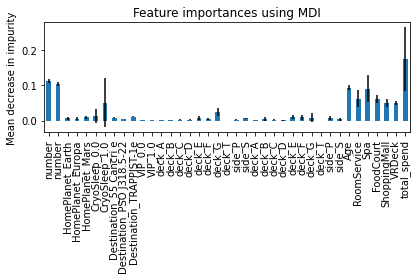

In [49]:
importances = clf.feature_importances_

forest_importances = pd.Series(importances, index=final_test_feature_df.columns)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [50]:
important_features = ['Age','RoomService','Spa','FoodCourt','ShoppingMall','VRDeck'] # Adding Cryosleep makes the result worse

X_train, X_test, y_train, y_test = train_test_split(final_feature_df[important_features], train_df.Transported, test_size=0.2)

clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.777458309373203


In [51]:
# Reducing features and resubmitting
y_sub = clf.predict(final_test_feature_df[important_features])

pd.merge(test_df['PassengerId'],pd.DataFrame(y_sub,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('important_features_submission.csv',index=False)

# Score: 0.49988

In [52]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Applying Grid Search

In [53]:
parameters = {'n_estimators':(500,1000), 'max_depth':[5,10],'criterion':['gini','entropy','log_loss'],
                         'min_samples_split':[12,25,50]}
algo = RandomForestClassifier()

clf_gs = GridSearchCV(algo, parameters,verbose=3)

clf_gs.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.774 total time=   1.5s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.787 total time=   1.6s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.787 total time=   1.6s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.796 total time=   1.6s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.779 total time=   1.5s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=1000;, score=0.773 total time=   3.3s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=1000;, score=0.787 total time=   3.4s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=1000;, score=0.786 total time=   3.3s
[CV 4/5] END criterion=

KeyboardInterrupt: 

In [54]:
clf_gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [49]:
clf_gs.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 50,
 'n_estimators': 500}

In [55]:
clf = RandomForestClassifier(criterion='entropy',max_depth=10,min_samples_split=50,n_estimators = 500)

X_train, X_test, y_train, y_test = train_test_split(final_feature_df, train_df.Transported, test_size=0.2)

clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8021851638872916


In [56]:
# Re-training model with all train data
clf.fit(final_feature_df,train_df.Transported)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=50,
                       n_estimators=500)

In [83]:
y_sub = pd.Series(y_sub).replace({1:'True',0:'False'}).values

In [84]:
pd.merge(test_df['PassengerId'],pd.DataFrame(y_sub,columns=['Transported']),left_index=True,right_index=True)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [85]:
y_sub = clf.predict(final_test_feature_df)
y_sub = pd.Series(y_sub).replace({1:'True',0:'False'}).values

pd.merge(test_df['PassengerId'],pd.DataFrame(y_sub,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('grid_search_submission.csv',index=False)